In [1]:
"""

This code read the file 'percentages_experimental_cell_types.xlsx' to get the % of the different cell types obtained experimentally
It takes the csv files produced by the model (folder 'solutions lamX') and select the 5 solutions closest to the experimental values and presenting
the smallest amount of modifications to go from control to cuff network.
Then, it analyses this solutions to get the % of cell types in control, dishinibited and cuff conditions in the differents solutions found by the model.
It give also the % of transformations from one cell type into an other cell type when going from control to cuff condition.
It generates the files:
1) percentages_BSPHC_model_lamX.xlsx used for Fig. S9A
2) percentages_conc_cell_types_model_lamX.xlsx used for Fig. 7B, Fig. 7C, S9B, S9C, Table 2, Table 3, Table 4
3) Percentages_transfo_control_to_CCI_lamX.xlsx Used for Fig. 7D
4) Transformations_Control_CCI_lamX.xlsx used for Fig.S10
5) Percentage_Control_cell_types_among_CCI_responders_lamX.xlsx used for Fig.S10

To generate these files, please chose the lamina (see just below) and run the full code

Importantly, in this code cuff and CCI are synonymous and for the Dynamic modality, we use the letter 'B' for brush.
"""



"\n\nThis code read the file 'percentages_experimental_cell_types.xlsx' to get the % of the different cell types obtained experimentally\nIt takes the csv files produced by the model (folder 'solutions lamX') and select the 5 solutions closest to the experimental values and presenting\nthe smallest amount of modifications to go from control to cuff network.\nThen, it analyses this solutions to get the % of cell types in control, dishinibited and cuff conditions in the differents solutions found by the model.\nIt give also the % of transformations from one cell type into an other cell type when going from control to cuff condition.\nIt generates the files:\n1) percentages_BSPHC_model_lamX.xlsx used for Fig. S9A\n2) percentages_conc_cell_types_model_lamX.xlsx used for Fig. 7B, Fig. 7C, S9B, S9C, Table 2, Table 3, Table 4\n3) Percentages_transfo_control_to_CCI_lamX.xlsx Used for Fig. 7D\n4) Transformations_Control_CCI_lamX.xlsx used for Fig.S10\n5) Percentage_Control_cell_types_among_CCI_

In [2]:
#Choose the lamina results to analyse
#lamina can be 'all' (all DH results pooled), '1' (lamina I and IIo of DH), '2' (lamina IIi of DH) or '3' (lamina III-V of DH)

lamina_chosen='all'

In [3]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import math
from collections import Counter
from matplotlib.patches import ConnectionPatch
import os
import scipy


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\mizbili\AppData\Local\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "C:\Users\mizbili\AppData\Local\anaconda3\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "C:\Users\mizbili\AppData\Local\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 701, in start
    self.io_loop.start(

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.



In [4]:
#Define Functions for the analysis of the model results

def calculate_perc_in_list(item=0,list_to_calculate=[]):

    percentage = (len([ele for ele in list_to_calculate if ele == item]) / len(list_to_calculate)) * 100
    percentage = round(percentage,n_number_post_coma)

    return percentage


def create_dict_perc_types(list_cells=[],modalities_list=[],list_all_possible_types=[]):
    
    list_cells_types=[0]*len(list_cells)
    for ind_cell, cell in enumerate(list_cells):
        str_type=''
        for input_value,modality in zip(cell,modalities_list):
            if input_value==1:
                str_type=str_type+modality
        if str_type=='':
            str_type='null'
        list_cells_types[ind_cell]=str_type

    dict_percentage_types={}
    for possible_cell_type in list_all_possible_types:
        percentage = calculate_perc_in_list(item=possible_cell_type,list_to_calculate=list_cells_types)
        dict_percentage_types[possible_cell_type]=percentage

    return dict_percentage_types


def calculate_cell_type(cell=[],modalities_list=[]):

    str_type=''
    for input_value,modality in zip(cell,modalities_list):
        if input_value==1:
            str_type=str_type+modality
    if str_type=='':
        str_type='null'
    cell_type=str_type

    return cell_type


def calculate_err(dict_percentage_types_CCI={},dict_test={},cell_type='',precision_level=0):

    err = round(dict_percentage_types_CCI[cell_type]-dict_test[cell_type],n_number_post_coma)
    real_err = err
    accepted_err=dict_percentage_types_CCI[cell_type]*precision_level
    if accepted_err<1 and accepted_err>0:
        accepted_err=1
    accepted_err=round(accepted_err,n_number_post_coma)
    if err>=-accepted_err and err<=accepted_err:
        err = 0
    else:
        if err>0:
            err=err-accepted_err
        elif err<0:
            err=err+accepted_err
    err = round(err,n_number_post_coma)

    return err,real_err


def compare_two_perc_dict(dict_test={},dict_ref={},precision_level=0):
    
    count_perc_diff=0
    for cell_type in dict_ref.keys():
        err = calculate_err(dict_percentage_types_CCI=dict_ref,
                            dict_test=dict_test,
                            cell_type=cell_type,
                            precision_level=precision_level)
        count_perc_diff=count_perc_diff+np.abs(err)
        
    return count_perc_diff


def BFS_all_paths(graph, start, goal):
    explored = []

    # Queue for traversing the graph in the BFS
    queue = [[start]]

    # If the desired node is reached
    if start == goal:
        return [[start]]

    # List to store all the possible paths
    all_paths = []

    # Loop to traverse the graph with the help of the queue
    while queue:
        path = queue.pop(0)
        node = path[-1]

        # Condition to check if the current node is not visited
        if node not in explored:
            neighbours = graph[node]

            # Loop to iterate over the neighbours of the node
            for neighbour in neighbours:
                new_path = list(path)
                new_path.append(neighbour)
                queue.append(new_path)

                # Condition to check if the neighbour node is the goal
                if neighbour == goal:
                    all_paths.append(new_path)
                    queue.remove(new_path)

            explored.append(node)

    return all_paths


def plot_graph_transfo(list_CCI_taken=[],list_cells_control=[],modalities_list=[],color_list=[]):

    list_cells_types_cont=[0]*len(list_cells_control)
    for ind_cell, cell in enumerate(list_cells_control):
        str_type=''
        for input_value,modality in zip(cell,modalities_list):
            if input_value==1:
                str_type=str_type+modality
        if str_type=='':
            str_type='null'
        list_cells_types_cont[ind_cell]=str_type

    list_cells_types_CCI=[0]*len(list_CCI_taken)
    for ind_cell, cell in enumerate(list_CCI_taken):
        str_type=''
        for input_value,modality in zip(cell,modalities_list):
            if input_value==1:
                str_type=str_type+modality
        if str_type=='':
            str_type='null'
        list_cells_types_CCI[ind_cell]=str_type

    list_transformations=[]
    for type_cont,type_CCI in zip(list_cells_types_cont,list_cells_types_CCI):
        string=type_cont+'_'+type_CCI
        list_transformations.append(string)

    dict_tranformations_count=Counter(list_transformations)

    n_comb=0
    for k in range(len(modalities_list)+1):
        n_comb=n_comb+math.comb(len(modalities_list), k)
    list_all_possible_types=[0]*n_comb
    ind_comb=0
    for L in range(len(modalities_list) + 1):
        for subset in itertools.combinations(modalities_list, L):
            str_type=''
            for ele in subset:
                str_type=str_type+str(ele)
            if str_type=='':
                str_type='null'
            list_all_possible_types[ind_comb]=str_type
            ind_comb=ind_comb+1

    fig, ax = plt.subplots()

    list_y=[]
    list_x1=[]
    list_x2=[]
    dict_type_y_index={}
    for index, possible_type in enumerate(list_all_possible_types):
        list_y.append(index+1)
        list_x1.append(1)
        list_x2.append(2)
        dict_type_y_index[possible_type]=index+1


    ax.scatter(list_x1,list_y,color=color_list,s=15,edgecolors='k',linewidths=0.5)
    ax.scatter(list_x2,list_y,color=color_list,s=15,edgecolors='k',linewidths=0.5)
    ax.set_xlim(0,3)

    for index, txt in enumerate(list_all_possible_types):
        plt.annotate(txt, (list_x1[index]-0.25, list_y[index]-0.3),size=8)
        plt.annotate(txt, (list_x2[index]+0.05, list_y[index]-0.3),size=8)

    for transfo in dict_tranformations_count.keys():
        if transfo!='null_null':
            splitted=transfo.split('_')
            type_cont=splitted[0]
            type_CCI=splitted[1]
            nb_transfo=dict_tranformations_count[transfo]
            xyA = (1.0, dict_type_y_index[type_cont])  # in axes coordinates
            xyB = (2.0, dict_type_y_index[type_CCI])
            coords='data'
            con = ConnectionPatch(xyA=xyA, xyB=xyB, coordsA=coords, coordsB=coords, arrowstyle="-",shrinkA = 5, shrinkB = 5)
            con.set_linewidth(nb_transfo/50)
            ax.add_artist(con)

    plt.show()
    
    return dict_tranformations_count

In [5]:
#Create the dictionnaries of experimental % of cell types in term of modalities (B,S,P,H,C,BS,BP,ect...)
#dict_percentage_types_control : % in control condition
#dict_percentage_types_control_desinhib : % after deshinibition
#dict_percentage_types_CCI : % in CCI condition

modalities_list = ['B', 'S', 'P', 'H', 'C']

list_all_possible_cells = [list(i) for i in itertools.product([0, 1,-1], repeat=5)]
n_comb=0
for k in range(len(modalities_list)+1):
    n_comb=n_comb+math.comb(len(modalities_list), k)
list_all_possible_types=[0]*n_comb
ind_comb=0
for L in range(len(modalities_list) + 1):
    for subset in itertools.combinations(modalities_list, L):
        str_type=''
        for ele in subset:
            str_type=str_type+str(ele)
        if str_type=='':
            str_type='null'
        list_all_possible_types[ind_comb]=str_type
        ind_comb=ind_comb+1





precision_level=30/100
n_number_post_coma=1
    
n_cells_in_networks=1000

dict_df = pd.read_excel('percentages_experimental_cell_types.xlsx', 
                   sheet_name=['pre_post_CON all','post_pre_CON all','CCI all','pre_post_CON lam 1','post_pre_CON lam 1','CCI lam 1','pre_post_CON lam 2','post_pre_CON lam 2','CCI lam 2','pre_post_CON lam 3','post_pre_CON lam 3','CCI lam 3'])
pre_post_con_df = dict_df.get('pre_post_CON all')
post_pre_con_df = dict_df.get('post_pre_CON all')
cci_df = dict_df.get('CCI all')
pre_post_con_df_lam1 = dict_df.get('pre_post_CON lam 1')
post_pre_con_df_lam1 = dict_df.get('post_pre_CON lam 1')
cci_df_lam1 = dict_df.get('CCI lam 1')
pre_post_con_df_lam2 = dict_df.get('pre_post_CON lam 2')
post_pre_con_df_lam2 = dict_df.get('post_pre_CON lam 2')
cci_df_lam2 = dict_df.get('CCI lam 2')
pre_post_con_df_lam3 = dict_df.get('pre_post_CON lam 3')
post_pre_con_df_lam3 = dict_df.get('post_pre_CON lam 3')
cci_df_lam3 = dict_df.get('CCI lam 3')

if lamina_chosen=='all':
    df_post=post_pre_con_df
    df_pre=pre_post_con_df
    df_cci=cci_df
elif lamina_chosen=='1':
    df_post=post_pre_con_df_lam1
    df_pre=pre_post_con_df_lam1
    df_cci=cci_df_lam1
elif lamina_chosen=='2':
    df_post=post_pre_con_df_lam2
    df_pre=pre_post_con_df_lam2
    df_cci=cci_df_lam2
elif lamina_chosen=='3':
    df_post=post_pre_con_df_lam3
    df_pre=pre_post_con_df_lam3
    df_cci=cci_df_lam3
    

    
dict_percentage_types_control={}
for index_col,col_name in enumerate(df_pre.columns.values.tolist()):
    splitted=col_name.split('(')
    prebicu_cell_type=splitted[0].replace(' ','')
    perc_prebicu_cell_type=splitted[1].replace(')','')
    perc_prebicu_cell_type=float(perc_prebicu_cell_type)
    perc_prebicu_cell_type = round(perc_prebicu_cell_type,n_number_post_coma)
    dict_percentage_types_control[prebicu_cell_type] = perc_prebicu_cell_type
    
dict_percentage_types_control_desinhib={}
for index_col,col_name in enumerate(df_post.columns.values.tolist()):
    splitted=col_name.split('(')
    postbicu_cell_type=splitted[0].replace(' ','')
    perc_postbicu_cell_type=splitted[1].replace(')','')
    perc_postbicu_cell_type=float(perc_postbicu_cell_type)
    perc_postbicu_cell_type = round(perc_postbicu_cell_type,n_number_post_coma)
    dict_percentage_types_control_desinhib[postbicu_cell_type] = perc_postbicu_cell_type

dict_percentage_types_CCI={}
for ele in list_all_possible_types:
    dict_percentage_types_CCI[ele]=0.0
for index_col,col_name in enumerate(df_cci.columns.values.tolist()):
    splitted=col_name.split('(')
    CCI_cell_type=splitted[0].replace(' ','')
    perc_CCI_cell_type=splitted[1].replace(')','')
    perc_CCI_cell_type=float(perc_CCI_cell_type)
    perc_CCI_cell_type=round(perc_CCI_cell_type,n_number_post_coma)
    dict_percentage_types_CCI[CCI_cell_type]=perc_CCI_cell_type

solutions lam3/

solution_nb_0_err_0.3.csv

nb bad perc control: 0
real err control: 4.7

BSP
5.9
8.0
-0.3
nb bad perc control desinhib: 1
real err control desinhib: 14.5

nb bad perc CCI: 0
real err CCI: 32.50000000000001

nb_bad_mut: 0

nb_mut_per_cell: 0.4785214785214785




solution_nb_100_err_0.3.csv

nb bad perc control: 0
real err control: 12.299999999999999

BSP
5.9
8.1
-0.4
nb bad perc control desinhib: 1
real err control desinhib: 25.700000000000003

nb bad perc CCI: 0
real err CCI: 32.89999999999999

nb_bad_mut: 0

nb_mut_per_cell: 0.4255744255744256




solution_nb_101_err_0.3.csv

nb bad perc control: 0
real err control: 5.7

BSP
5.9
7.8
-0.1
nb bad perc control desinhib: 1
real err control desinhib: 12.499999999999998

nb bad perc CCI: 0
real err CCI: 32.5

nb_bad_mut: 0

nb_mut_per_cell: 0.4675324675324675




solution_nb_102_err_0.3.csv

nb bad perc control: 0
real err control: 3.9000000000000004

BSP
5.9
7.8
-0.1
nb bad perc control desinhib: 1
real err control desinhi

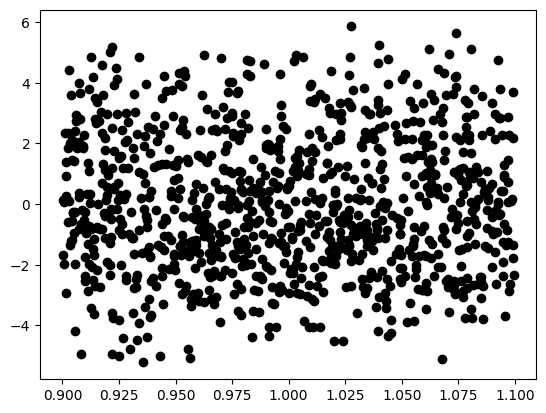

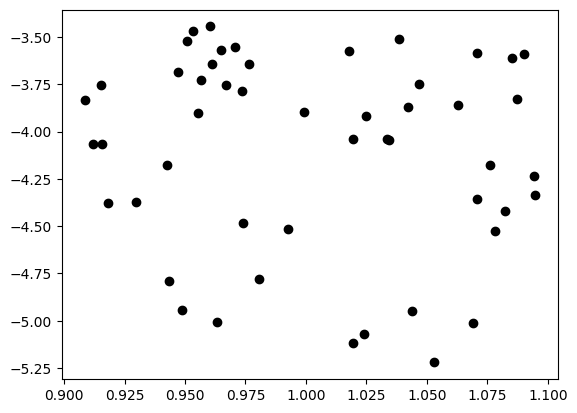

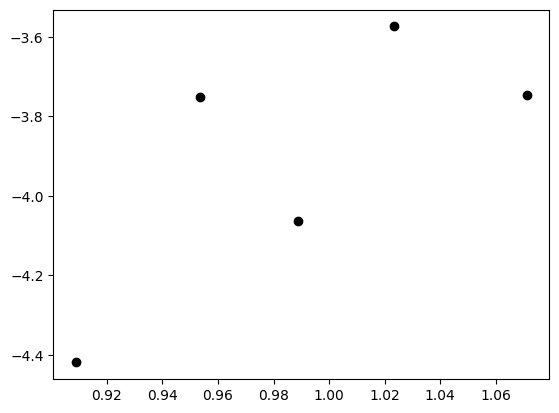

In [6]:
#From the 1000 solutions of possible networks generated by the model (csv files in forlders 'solution lam1', 'solution lam2', 'solution lam3', 'solution lamall')
#We select the 50 solutions closest to the experimental % (in control, deshibition and CCI)
#From theses 50 solutions, we select the 5 solutions displaying the smallest amount of mutations to convert the control network to CCI network
#(one mutation means turning a 0 to a 1 in a given cell, meaning this modality has been deshinibited for this cell)

list_mut_per_cell=[]

list_real_err_cont=[]
list_real_err_CCI=[]
list_real_err_cont_desinhib=[]

folder='solutions lam'+lamina_chosen+'/'
print(folder)

list_all_files=os.listdir(folder)

for file in list_all_files:

    print()
    
    print(file)

    print()

    df = pd.read_csv(folder+file,sep=';')
    
    #extract list of cells control and CCI
    list_cells_control=[]
    list_cells_CCI=[]
    for index_col,col_name in enumerate(df.columns.values.tolist()):
        if col_name=='Control':
            for ele in df.loc[:,col_name]:
                ele=ele.split('[')[1]
                ele=ele.split(']')[0]
                ele=ele.split(',')
                cell=[]
                for str_syn in ele:
                    cell.append(int(str_syn))
                list_cells_control.append(cell.copy())
        if col_name=='CCI':
            for ele in df.loc[:,col_name]:
                ele=ele.split('[')[1]
                ele=ele.split(']')[0]
                ele=ele.split(',')
                cell=[]
                for str_syn in ele:
                    cell.append(int(str_syn))
                list_cells_CCI.append(cell.copy())
                
    #check if % of cell types are ok in control
    dict_control_obtained=create_dict_perc_types(list_cells=list_cells_control,modalities_list=modalities_list,list_all_possible_types=list_all_possible_types)
    count_bad_perc_control=0
    count_real_err_control=0
    for ele in dict_control_obtained.keys():
        err,real_err = calculate_err(dict_percentage_types_CCI=dict_percentage_types_control,
                            dict_test=dict_control_obtained,
                            cell_type=ele,
                            precision_level=precision_level)
        count_real_err_control=count_real_err_control+np.abs(real_err)
        if err!=0:
            print(ele)
            print(dict_percentage_types_control[ele])
            print(dict_control_obtained[ele])
            print(err)
            count_bad_perc_control=count_bad_perc_control+1
    print('nb bad perc control:',count_bad_perc_control)
    print('real err control:',count_real_err_control)
    
    list_real_err_cont.append(count_real_err_control)
    
    print()
    
    
    #check if % of cell types are ok in control desinhib
    list_cells_control_desinhib=[]
    for ind_cell,cell in enumerate(list_cells_control):
        if 0 not in cell:
            list_cells_control_desinhib.append(cell.copy())
        else:
            new_cell=[]
            for ind_syn,syn in enumerate(cell):
                if syn!=0:
                    new_cell.append(syn)
                else:
                    new_cell.append(1)
            list_cells_control_desinhib.append(new_cell.copy())
            
            
    dict_control_desinhib_obtained=create_dict_perc_types(list_cells=list_cells_control_desinhib,modalities_list=modalities_list,list_all_possible_types=list_all_possible_types)
    count_bad_perc_control=0
    count_real_err_control=0
    for ele in dict_control_desinhib_obtained.keys():
        err,real_err = calculate_err(dict_percentage_types_CCI=dict_percentage_types_control_desinhib,
                            dict_test=dict_control_desinhib_obtained,
                            cell_type=ele,
                            precision_level=precision_level)
        count_real_err_control=count_real_err_control+np.abs(real_err)
        if err!=0:
            print(ele)
            print(dict_percentage_types_control_desinhib[ele])
            print(dict_control_desinhib_obtained[ele])
            print(err)
            count_bad_perc_control=count_bad_perc_control+1
    print('nb bad perc control desinhib:',count_bad_perc_control)
    print('real err control desinhib:',count_real_err_control)
    
    list_real_err_cont_desinhib.append(count_real_err_control)
    
    print()
    
    #check if % of cell types are ok in CCI
    dict_CCI_obtained=create_dict_perc_types(list_cells=list_cells_CCI,modalities_list=modalities_list,list_all_possible_types=list_all_possible_types)
    count_bad_perc_CCI=0
    count_real_err_CCI=0
    for ele in dict_CCI_obtained.keys():
        err,real_err  = calculate_err(dict_percentage_types_CCI=dict_percentage_types_CCI,
                            dict_test=dict_CCI_obtained,
                            cell_type=ele,
                            precision_level=precision_level)
        count_real_err_CCI=count_real_err_CCI+np.abs(real_err)
        if err!=0:
            print(ele)
            print(dict_percentage_types_CCI[ele])
            print(dict_CCI_obtained[ele])
            print(err)
            count_bad_perc_CCI=count_bad_perc_CCI+1
    print('nb bad perc CCI:',count_bad_perc_CCI)
    print('real err CCI:',count_real_err_CCI)
    
    list_real_err_CCI.append(count_real_err_CCI)
    
    print()
    
    #check if the only mutation are 0 turning into a 1
    count_bad_mut=0
    for cell1,cell2 in zip(list_cells_control,list_cells_CCI):
        for syn1,syn2 in zip(cell1,cell2):
            if syn1==-1 or syn1==1:
                if syn1!=syn2:
                    count_bad_mut=count_bad_mut+1
            elif syn2==-1 and syn1!=-1:
                count_bad_mut=count_bad_mut+1
    print('nb_bad_mut:',count_bad_mut)

    print()
    
    #count the number of mutations
    count_mut=0
    for cell1,cell2 in zip(list_cells_control,list_cells_CCI):
        for syn1,syn2 in zip(cell1,cell2):
            if syn1!=syn2:
                count_mut=count_mut+1
    count_mut_per_cell=count_mut/len(list_cells_control)
    print('nb_mut_per_cell:',count_mut_per_cell)
    list_mut_per_cell.append(count_mut_per_cell)
    
    print()
    print()
    print()

    
mean=np.mean(list_real_err_cont)
sd=np.std(list_real_err_cont)
list_real_err_cont_zscore=[]
for ele in list_real_err_cont:
    list_real_err_cont_zscore.append((ele-mean)/sd)
    
mean=np.mean(list_real_err_cont_desinhib)
sd=np.std(list_real_err_cont_desinhib)
list_real_err_cont_desinhib_zscore=[]
for ele in list_real_err_cont_desinhib:
    list_real_err_cont_desinhib_zscore.append((ele-mean)/sd)
    
mean=np.mean(list_real_err_CCI)
sd=np.std(list_real_err_CCI)
list_real_err_CCI_zscore=[]
for ele in list_real_err_CCI:
    list_real_err_CCI_zscore.append((ele-mean)/sd)

list_sum_zscore=[]
for ele1,ele2,ele3 in zip(list_real_err_cont_zscore,list_real_err_cont_desinhib_zscore,list_real_err_CCI_zscore):
    list_sum_zscore.append(ele1+ele2+ele3)
    
#sort 2 two lists at the same time in function of list_sum_zscore
list_sum_zscore,list_mut_per_cell, list_all_files = zip(*sorted(zip(list_sum_zscore,list_mut_per_cell, list_all_files)))
list_sum_zscore,list_mut_per_cell, list_all_files = (list(t) for t in zip(*sorted(zip(list_sum_zscore,list_mut_per_cell, list_all_files))))


x_axis=[]
for ele in list_sum_zscore:
    x_axis.append(random.uniform(0.9,1.1))
plt.plot(x_axis,list_sum_zscore,'ko')
plt.show()

list_selected_files=list_all_files[0:50]
list_sum_zscore=list_sum_zscore[0:50]
list_mut_per_cell=list_mut_per_cell[0:50]

x_axis=[]
for ele in list_sum_zscore:
    x_axis.append(random.uniform(0.9,1.1))
plt.plot(x_axis,list_sum_zscore,'ko')
plt.show()



#sort 2 two lists at the same time in function of list_mut_per_cell
list_mut_per_cell, list_sum_zscore,list_all_files = zip(*sorted(zip(list_mut_per_cell, list_sum_zscore,list_all_files)))
list_mut_per_cell, list_sum_zscore,list_all_files = (list(t) for t in zip(*sorted(zip(list_mut_per_cell, list_sum_zscore,list_all_files))))


list_selected_files=list_all_files[0:5]
list_sum_zscore=list_sum_zscore[0:5]
list_mut_per_cell=list_mut_per_cell[0:5]

x_axis=[]
for ele in list_sum_zscore:
    x_axis.append(random.uniform(0.9,1.1))
plt.plot(x_axis,list_sum_zscore,'ko')
plt.show()

In [7]:
#To obtain % of B, S, P, H, C in control, dis, cuff for each solution selected
#Creates the files percentages_BSPHC_model_lamX.xlsx
#Used for Fig. S9A

dict_perc_BSPHC_control={}
dict_perc_BSPHC_dis={}
dict_perc_BSPHC_cuff={}

for file in list_selected_files:
    
    print()
    
    print(file)

    print()

    df = pd.read_csv(folder+file,sep=';')
    
    #extract list of cells control and CCI
    list_cells_control=[]
    list_cells_CCI=[]
    for index_col,col_name in enumerate(df.columns.values.tolist()):
        if col_name=='Control':
            for ele in df.loc[:,col_name]:
                ele=ele.split('[')[1]
                ele=ele.split(']')[0]
                ele=ele.split(',')
                cell=[]
                for str_syn in ele:
                    cell.append(int(str_syn))
                list_cells_control.append(cell.copy())
        if col_name=='CCI':
            for ele in df.loc[:,col_name]:
                ele=ele.split('[')[1]
                ele=ele.split(']')[0]
                ele=ele.split(',')
                cell=[]
                for str_syn in ele:
                    cell.append(int(str_syn))
                list_cells_CCI.append(cell.copy())
                
    list_cells_control_desinhib=[]
    for ind_cell,cell in enumerate(list_cells_control):
        if 0 not in cell:
            list_cells_control_desinhib.append(cell.copy())
        else:
            new_cell=[]
            for ind_syn,syn in enumerate(cell):
                if syn!=0:
                    new_cell.append(syn)
                else:
                    new_cell.append(1)
            list_cells_control_desinhib.append(new_cell.copy())
                
    dict_control_obtained=create_dict_perc_types(list_cells=list_cells_control,modalities_list=modalities_list,list_all_possible_types=list_all_possible_types)
    dict_control_desinhib_obtained=create_dict_perc_types(list_cells=list_cells_control_desinhib,modalities_list=modalities_list,list_all_possible_types=list_all_possible_types)
    dict_CCI_obtained=create_dict_perc_types(list_cells=list_cells_CCI,modalities_list=modalities_list,list_all_possible_types=list_all_possible_types)
    
    list_B=[]
    list_S=[]
    list_P=[]
    list_H=[]
    list_C=[]
    for key in dict_control_obtained.keys():
        if 'B' in key:
            list_B.append(dict_control_obtained[key])
        if 'S' in key:
            list_S.append(dict_control_obtained[key])
        if 'P' in key:
            list_P.append(dict_control_obtained[key])
        if 'H' in key:
            list_H.append(dict_control_obtained[key])
        if 'C' in key:
            list_C.append(dict_control_obtained[key])

    B_perc=np.sum(list_B)
    S_perc=np.sum(list_S)
    P_perc=np.sum(list_P)
    H_perc=np.sum(list_H)
    C_perc=np.sum(list_C)


    print('Control Condition')
    print('% of B: ',B_perc)
    print('% of S: ',S_perc)
    print('% of P: ',P_perc)
    print('% of H: ',H_perc)
    print('% of C: ',C_perc)
    print()

    dict_perc_BSPHC_control[file]=[B_perc,S_perc,P_perc,H_perc,C_perc]


    
    
    list_B=[]
    list_S=[]
    list_P=[]
    list_H=[]
    list_C=[]
    for key in dict_control_desinhib_obtained.keys():
        if 'B' in key:
            list_B.append(dict_control_desinhib_obtained[key])
        if 'S' in key:
            list_S.append(dict_control_desinhib_obtained[key])
        if 'P' in key:
            list_P.append(dict_control_desinhib_obtained[key])
        if 'H' in key:
            list_H.append(dict_control_desinhib_obtained[key])
        if 'C' in key:
            list_C.append(dict_control_desinhib_obtained[key])

    B_perc=np.sum(list_B)
    S_perc=np.sum(list_S)
    P_perc=np.sum(list_P)
    H_perc=np.sum(list_H)
    C_perc=np.sum(list_C)

    print('Desinhib Condition')
    print('% of B: ',B_perc)
    print('% of S: ',S_perc)
    print('% of P: ',P_perc)
    print('% of H: ',H_perc)
    print('% of C: ',C_perc)
    print()

    dict_perc_BSPHC_dis[file]=[B_perc,S_perc,P_perc,H_perc,C_perc]



    
    
    list_B=[]
    list_S=[]
    list_P=[]
    list_H=[]
    list_C=[]
    for key in dict_CCI_obtained.keys():
        if 'B' in key:
            list_B.append(dict_CCI_obtained[key])
        if 'S' in key:
            list_S.append(dict_CCI_obtained[key])
        if 'P' in key:
            list_P.append(dict_CCI_obtained[key])
        if 'H' in key:
            list_H.append(dict_CCI_obtained[key])
        if 'C' in key:
            list_C.append(dict_CCI_obtained[key])

    B_perc=np.sum(list_B)
    S_perc=np.sum(list_S)
    P_perc=np.sum(list_P)
    H_perc=np.sum(list_H)
    C_perc=np.sum(list_C)

    print('CCI Condition')
    print('% of B: ',B_perc)
    print('% of S: ',S_perc)
    print('% of P: ',P_perc)
    print('% of H: ',H_perc)
    print('% of C: ',C_perc)
    print()

    dict_perc_BSPHC_cuff[file]=[B_perc,S_perc,P_perc,H_perc,C_perc]

print()
print('perc control')
df_perc_BSPHC_control=pd.DataFrame.from_dict(dict_perc_BSPHC_control)
df_perc_BSPHC_control.rename(index={0: modalities_list[0], 1: modalities_list[1], 2: modalities_list[2], 3: modalities_list[3], 4: modalities_list[4]}, inplace=True)
print(df_perc_BSPHC_control)
print()
print('perc dis')
df_perc_BSPHC_dis=pd.DataFrame.from_dict(dict_perc_BSPHC_dis)
df_perc_BSPHC_dis.rename(index={0: modalities_list[0], 1: modalities_list[1], 2: modalities_list[2], 3: modalities_list[3], 4: modalities_list[4]}, inplace=True)
print(df_perc_BSPHC_dis)
print()
print('perc cuff')
df_perc_BSPHC_cuff=pd.DataFrame.from_dict(dict_perc_BSPHC_cuff)
df_perc_BSPHC_cuff.rename(index={0: modalities_list[0], 1: modalities_list[1], 2: modalities_list[2], 3: modalities_list[3], 4: modalities_list[4]}, inplace=True)
print(df_perc_BSPHC_cuff)


with pd.ExcelWriter('percentages_BSPHC_model_lam'+lamina_chosen+'.xlsx') as writer:
    df_perc_BSPHC_control.to_excel(writer, sheet_name='Control')
    df_perc_BSPHC_dis.to_excel(writer, sheet_name='Dis')
    df_perc_BSPHC_cuff.to_excel(writer, sheet_name='Cuff')



solution_nb_22_err_0.3.csv

Control Condition
% of B:  4.6
% of S:  4.3
% of P:  12.5
% of H:  6.3
% of C:  1.8

Desinhib Condition
% of B:  23.5
% of S:  21.9
% of P:  34.0
% of H:  13.400000000000002
% of C:  5.0

CCI Condition
% of B:  18.7
% of S:  19.6
% of P:  25.299999999999997
% of H:  7.8
% of C:  4.0


solution_nb_73_err_0.3.csv

Control Condition
% of B:  4.9
% of S:  3.8
% of P:  12.399999999999999
% of H:  5.9
% of C:  2.1

Desinhib Condition
% of B:  26.5
% of S:  22.5
% of P:  35.9
% of H:  15.299999999999999
% of C:  6.699999999999999

CCI Condition
% of B:  18.1
% of S:  19.6
% of P:  25.799999999999997
% of H:  8.0
% of C:  3.9


solution_nb_97_err_0.3.csv

Control Condition
% of B:  4.8
% of S:  3.4000000000000004
% of P:  12.0
% of H:  6.4
% of C:  1.6

Desinhib Condition
% of B:  25.0
% of S:  21.0
% of P:  33.5
% of H:  13.899999999999999
% of C:  5.4

CCI Condition
% of B:  18.4
% of S:  19.4
% of P:  25.6
% of H:  8.1
% of C:  3.0


solution_nb_367_err_0.3.csv


In [8]:
#To obtain % of 'Silent','LTM','WDR_M','WDR_MT','NS_M','NS_T','NS_MT' in control, dis, cuff for each solution selected
#Creates the files percentages_conc_cell_types_model_lamX.xlsx
#Used for Fig. 7B, Fig. 7C, S9B, S9C, Table 2, Table 3, Table 4

dict_perc_conc_cell_types_control={}
dict_perc_conc_cell_types_cuff={}
dict_perc_conc_cell_types_dis={}

for file in list_selected_files:
    
    print()
    
    print(file)

    print()

    df = pd.read_csv(folder+file,sep=';')
    
    #extract list of cells control and CCI
    list_cells_control=[]
    list_cells_cuff=[]
    for index_col,col_name in enumerate(df.columns.values.tolist()):
        if col_name=='Control':
            for ele in df.loc[:,col_name]:
                ele=ele.split('[')[1]
                ele=ele.split(']')[0]
                ele=ele.split(',')
                cell=[]
                for str_syn in ele:
                    cell.append(int(str_syn))
                list_cells_control.append(cell.copy())
        if col_name=='CCI':
            for ele in df.loc[:,col_name]:
                ele=ele.split('[')[1]
                ele=ele.split(']')[0]
                ele=ele.split(',')
                cell=[]
                for str_syn in ele:
                    cell.append(int(str_syn))
                list_cells_cuff.append(cell.copy())
                
    list_cells_control_desinhib=[]
    for ind_cell,cell in enumerate(list_cells_control):
        if 0 not in cell:
            list_cells_control_desinhib.append(cell.copy())
        else:
            new_cell=[]
            for ind_syn,syn in enumerate(cell):
                if syn!=0:
                    new_cell.append(syn)
                else:
                    new_cell.append(1)
            list_cells_control_desinhib.append(new_cell.copy())




    #turn list cells control into list of Silent, LTM, WDR and NS
    list_conc_cell_types_control=[]
    for cell in list_cells_control:
        cell_type = calculate_cell_type(cell=cell,modalities_list=modalities_list)
        if cell_type=='null':
            conc_cell_type='Silent'
        elif 'B' in cell_type or 'S' in cell_type:
            if 'P' not in cell_type and 'H' not in cell_type and 'C' not in cell_type:
                conc_cell_type='LTM'
            elif 'P' in cell_type and 'H' not in cell_type and 'C' not in cell_type:
                conc_cell_type='WDR_M'
            else:
                conc_cell_type='WDR_MT'
        else:
            if 'P' in cell_type:
                if 'H' in cell_type or 'C' in cell_type:
                    conc_cell_type='NS_MT'
                else:
                    conc_cell_type='NS_M'
            else:
                conc_cell_type='NS_T'
        list_conc_cell_types_control.append(conc_cell_type)
    #turn list cells cuff into list of Silent, LTM, WDR and NS
    list_conc_cell_types_cuff=[]
    for cell in list_cells_cuff:
        cell_type = calculate_cell_type(cell=cell,modalities_list=modalities_list)
        if cell_type=='null':
            conc_cell_type='Silent'
        elif 'B' in cell_type or 'S' in cell_type:
            if 'P' not in cell_type and 'H' not in cell_type and 'C' not in cell_type:
                conc_cell_type='LTM'
            elif 'P' in cell_type and 'H' not in cell_type and 'C' not in cell_type:
                conc_cell_type='WDR_M'
            else:
                conc_cell_type='WDR_MT'
        else:
            if 'P' in cell_type:
                if 'H' in cell_type or 'C' in cell_type:
                    conc_cell_type='NS_MT'
                else:
                    conc_cell_type='NS_M'
            else:
                conc_cell_type='NS_T'
        list_conc_cell_types_cuff.append(conc_cell_type)
    #turn list cells desinhib into list of Silent, LTM, WDR and NS
    list_conc_cell_types_dis=[]
    for cell in list_cells_control_desinhib:
        cell_type = calculate_cell_type(cell=cell,modalities_list=modalities_list)
        if cell_type=='null':
            conc_cell_type='Silent'
        elif 'B' in cell_type or 'S' in cell_type:
            if 'P' not in cell_type and 'H' not in cell_type and 'C' not in cell_type:
                conc_cell_type='LTM'
            elif 'P' in cell_type and 'H' not in cell_type and 'C' not in cell_type:
                conc_cell_type='WDR_M'
            else:
                conc_cell_type='WDR_MT'
        else:
            if 'P' in cell_type:
                if 'H' in cell_type or 'C' in cell_type:
                    conc_cell_type='NS_MT'
                else:
                    conc_cell_type='NS_M'
            else:
                conc_cell_type='NS_T'
        list_conc_cell_types_dis.append(conc_cell_type)




    
    list_possible_conc_cell_types=['Silent','LTM','WDR_M','WDR_MT','NS_M','NS_T','NS_MT']
    
    list_trans=[]
    for possible_conc_cell_type in list_possible_conc_cell_types:
        percentage = calculate_perc_in_list(item=possible_conc_cell_type,list_to_calculate=list_conc_cell_types_control)
        list_trans.append(percentage)
    dict_perc_conc_cell_types_control[file]=list_trans
    
    list_trans=[]
    for possible_conc_cell_type in list_possible_conc_cell_types:
        percentage = calculate_perc_in_list(item=possible_conc_cell_type,list_to_calculate=list_conc_cell_types_cuff)
        list_trans.append(percentage)
    dict_perc_conc_cell_types_cuff[file]=list_trans
    
    list_trans=[]
    for possible_conc_cell_type in list_possible_conc_cell_types:
        percentage = calculate_perc_in_list(item=possible_conc_cell_type,list_to_calculate=list_conc_cell_types_dis)
        list_trans.append(percentage)
    dict_perc_conc_cell_types_dis[file]=list_trans





    

list_possible_conc_cell_types=['Silent','LTM','WDR_M','WDR_MT','NS_M','NS_T','NS_MT']

print()
print('perc control')
df_perc_conc_cell_types_control=pd.DataFrame.from_dict(dict_perc_conc_cell_types_control)
df_perc_conc_cell_types_control.rename(index={0: list_possible_conc_cell_types[0], 1: list_possible_conc_cell_types[1], 2: list_possible_conc_cell_types[2], 3: list_possible_conc_cell_types[3], 4: list_possible_conc_cell_types[4], 5: list_possible_conc_cell_types[5], 6: list_possible_conc_cell_types[6]}, inplace=True)
print(df_perc_conc_cell_types_control)
print()
print('perc dis')
df_perc_conc_cell_types_dis=pd.DataFrame.from_dict(dict_perc_conc_cell_types_dis)
df_perc_conc_cell_types_dis.rename(index={0: list_possible_conc_cell_types[0], 1: list_possible_conc_cell_types[1], 2: list_possible_conc_cell_types[2], 3: list_possible_conc_cell_types[3], 4: list_possible_conc_cell_types[4], 5: list_possible_conc_cell_types[5], 6: list_possible_conc_cell_types[6]}, inplace=True)
print(df_perc_conc_cell_types_dis)
print()
print('perc cuff')
df_perc_conc_cell_types_cuff=pd.DataFrame.from_dict(dict_perc_conc_cell_types_cuff)
df_perc_conc_cell_types_cuff.rename(index={0: list_possible_conc_cell_types[0], 1: list_possible_conc_cell_types[1], 2: list_possible_conc_cell_types[2], 3: list_possible_conc_cell_types[3], 4: list_possible_conc_cell_types[4], 5: list_possible_conc_cell_types[5], 6: list_possible_conc_cell_types[6]}, inplace=True)
print(df_perc_conc_cell_types_cuff)


with pd.ExcelWriter('percentages_conc_cell_types_model_lam'+lamina_chosen+'.xlsx') as writer:
    df_perc_conc_cell_types_control.to_excel(writer, sheet_name='Control')
    df_perc_conc_cell_types_dis.to_excel(writer, sheet_name='Dis')
    df_perc_conc_cell_types_cuff.to_excel(writer, sheet_name='Cuff')


solution_nb_22_err_0.3.csv


solution_nb_73_err_0.3.csv


solution_nb_97_err_0.3.csv


solution_nb_367_err_0.3.csv


solution_nb_245_err_0.3.csv


perc control
        solution_nb_22_err_0.3.csv  solution_nb_73_err_0.3.csv  \
Silent                        81.7                        80.9   
LTM                            2.8                         3.6   
WDR_M                          2.5                         2.5   
WDR_MT                         1.8                         1.3   
NS_M                           6.7                         7.1   
NS_T                           3.0                         3.1   
NS_MT                          1.5                         1.5   

        solution_nb_97_err_0.3.csv  solution_nb_367_err_0.3.csv  \
Silent                        81.3                         81.6   
LTM                            3.6                          3.3   
WDR_M                          2.2                          2.5   
WDR_MT                         1.2        

In [9]:
#To get % of NS,LTM,Silent, WDR in CCI and % of their origin in control condition
#Create the files Percentages_transfo_control_to_CCI_lamX.xlsx
#Used for Fig. 7D

list_dict_transfo_cell_types_control_CCI=[]
list_dict_transfo_cell_types_control_CCI_B_responders=[]
list_dict_transfo_cell_types_control_CCI_S_responders=[]
list_dict_transfo_cell_types_control_CCI_P_responders=[]
list_dict_transfo_cell_types_control_CCI_H_responders=[]
list_dict_transfo_cell_types_control_CCI_C_responders=[]
for file in list_selected_files:
    
    print()
    
    print(file)

    print()

    df = pd.read_csv(folder+file,sep=';')
    
    #extract list of cells control and CCI
    list_cells_control=[]
    list_cells_CCI=[]
    for index_col,col_name in enumerate(df.columns.values.tolist()):
        if col_name=='Control':
            for ele in df.loc[:,col_name]:
                ele=ele.split('[')[1]
                ele=ele.split(']')[0]
                ele=ele.split(',')
                cell=[]
                for str_syn in ele:
                    cell.append(int(str_syn))
                list_cells_control.append(cell.copy())
        if col_name=='CCI':
            for ele in df.loc[:,col_name]:
                ele=ele.split('[')[1]
                ele=ele.split(']')[0]
                ele=ele.split(',')
                cell=[]
                for str_syn in ele:
                    cell.append(int(str_syn))
                list_cells_CCI.append(cell.copy())
                
    
    #turn list cells control into list of Silent, LTM, WDR and NS
    list_conc_cell_types_control=[]
    for cell in list_cells_control:
        cell_type = calculate_cell_type(cell=cell,modalities_list=modalities_list)
        if cell_type=='null':
            conc_cell_type='Silent'
        elif 'B' in cell_type or 'S' in cell_type:
            if 'P' not in cell_type and 'H' not in cell_type and 'C' not in cell_type:
                conc_cell_type='LTM'
            else:
                conc_cell_type='WDR'
        elif 'P' in cell_type or 'H' in cell_type or 'C' in cell_type:
            conc_cell_type='NS'
        list_conc_cell_types_control.append(conc_cell_type)
            
        
    
    #turn list cells CCI into list of Silent, LTM, WDR and NS
    list_conc_cell_types_CCI=[]
    list_index_B_responders_CCI=[]
    list_index_S_responders_CCI=[]
    list_index_P_responders_CCI=[]
    list_index_H_responders_CCI=[]
    list_index_C_responders_CCI=[]
    index=0
    for cell in list_cells_CCI:
        cell_type = calculate_cell_type(cell=cell,modalities_list=modalities_list)
        if cell_type=='null':
            conc_cell_type='Silent'
        elif 'B' in cell_type or 'S' in cell_type:
            if 'P' not in cell_type and 'H' not in cell_type and 'C' not in cell_type:
                conc_cell_type='LTM'
            else:
                conc_cell_type='WDR'
        elif 'P' in cell_type or 'H' in cell_type or 'C' in cell_type:
            conc_cell_type='NS'
        list_conc_cell_types_CCI.append(conc_cell_type)
        if 'B' in cell_type:
            list_index_B_responders_CCI.append(index)
        if 'S' in cell_type:
            list_index_S_responders_CCI.append(index)
        if 'P' in cell_type:
            list_index_P_responders_CCI.append(index)
        if 'H' in cell_type:
            list_index_H_responders_CCI.append(index)
        if 'C' in cell_type:
            list_index_C_responders_CCI.append(index)
        index=index+1
        
    
            
        
    #create list that associate conc_cell_types_control and conc_cell_types_CCI        
    list_transfo_control_CCI=[]
    for conc_cell_type_control,conc_cell_type_CCI in zip(list_conc_cell_types_control,list_conc_cell_types_CCI):
        list_transfo_control_CCI.append([conc_cell_type_control,conc_cell_type_CCI])
    list_all_transfo_possible=[]
    for transfo in list_transfo_control_CCI:
        if transfo not in list_all_transfo_possible:
            list_all_transfo_possible.append(transfo)
    dict_transfo_perc_control_CCI={}
    for transfo in list_all_transfo_possible:
        perc = (len([ele for ele in list_transfo_control_CCI if ele == transfo]) / len(list_transfo_control_CCI)) * 100
        dict_transfo_perc_control_CCI[str(transfo)]=perc
    #print(dict_transfo_perc_control_CCI)
    list_dict_transfo_cell_types_control_CCI.append(dict_transfo_perc_control_CCI)
    
    list_transfo_control_CCI_B_responders = [list_transfo_control_CCI[i] for i in list_index_B_responders_CCI]
    list_transfo_control_CCI_S_responders = [list_transfo_control_CCI[i] for i in list_index_S_responders_CCI]
    list_transfo_control_CCI_P_responders = [list_transfo_control_CCI[i] for i in list_index_P_responders_CCI]
    list_transfo_control_CCI_H_responders = [list_transfo_control_CCI[i] for i in list_index_H_responders_CCI]
    list_transfo_control_CCI_C_responders = [list_transfo_control_CCI[i] for i in list_index_C_responders_CCI]
    
    list_all_transfo_possible=[]
    for transfo in list_transfo_control_CCI_B_responders:
        if transfo not in list_all_transfo_possible:
            list_all_transfo_possible.append(transfo)
    dict_transfo_perc_control_CCI_B_responders={}
    for transfo in list_all_transfo_possible:
        perc = (len([ele for ele in list_transfo_control_CCI_B_responders if ele == transfo]) / len(list_transfo_control_CCI_B_responders)) * 100
        dict_transfo_perc_control_CCI_B_responders[str(transfo)]=perc
    list_dict_transfo_cell_types_control_CCI_B_responders.append(dict_transfo_perc_control_CCI_B_responders)
        
    list_all_transfo_possible=[]
    for transfo in list_transfo_control_CCI_S_responders:
        if transfo not in list_all_transfo_possible:
            list_all_transfo_possible.append(transfo)
    dict_transfo_perc_control_CCI_S_responders={}
    for transfo in list_all_transfo_possible:
        perc = (len([ele for ele in list_transfo_control_CCI_S_responders if ele == transfo]) / len(list_transfo_control_CCI_S_responders)) * 100
        dict_transfo_perc_control_CCI_S_responders[str(transfo)]=perc
    list_dict_transfo_cell_types_control_CCI_S_responders.append(dict_transfo_perc_control_CCI_S_responders)
        
    list_all_transfo_possible=[]
    for transfo in list_transfo_control_CCI_P_responders:
        if transfo not in list_all_transfo_possible:
            list_all_transfo_possible.append(transfo)
    dict_transfo_perc_control_CCI_P_responders={}
    for transfo in list_all_transfo_possible:
        perc = (len([ele for ele in list_transfo_control_CCI_P_responders if ele == transfo]) / len(list_transfo_control_CCI_P_responders)) * 100
        dict_transfo_perc_control_CCI_P_responders[str(transfo)]=perc
    list_dict_transfo_cell_types_control_CCI_P_responders.append(dict_transfo_perc_control_CCI_P_responders)
        
    list_all_transfo_possible=[]
    for transfo in list_transfo_control_CCI_H_responders:
        if transfo not in list_all_transfo_possible:
            list_all_transfo_possible.append(transfo)
    dict_transfo_perc_control_CCI_H_responders={}
    for transfo in list_all_transfo_possible:
        perc = (len([ele for ele in list_transfo_control_CCI_H_responders if ele == transfo]) / len(list_transfo_control_CCI_H_responders)) * 100
        dict_transfo_perc_control_CCI_H_responders[str(transfo)]=perc
    list_dict_transfo_cell_types_control_CCI_H_responders.append(dict_transfo_perc_control_CCI_H_responders)
        
    list_all_transfo_possible=[]
    for transfo in list_transfo_control_CCI_C_responders:
        if transfo not in list_all_transfo_possible:
            list_all_transfo_possible.append(transfo)
    dict_transfo_perc_control_CCI_C_responders={}
    for transfo in list_all_transfo_possible:
        perc = (len([ele for ele in list_transfo_control_CCI_C_responders if ele == transfo]) / len(list_transfo_control_CCI_C_responders)) * 100
        dict_transfo_perc_control_CCI_C_responders[str(transfo)]=perc
    list_dict_transfo_cell_types_control_CCI_C_responders.append(dict_transfo_perc_control_CCI_C_responders)
    
    
    
list_all_transfo_possible=[]
for dict_transfo_cell_types_control_CCI in list_dict_transfo_cell_types_control_CCI:
    for key in dict_transfo_cell_types_control_CCI.keys():
        if key not in list_all_transfo_possible:
            list_all_transfo_possible.append(key)
dict_mean_transfo_cell_types_control_CCI={}
for transfo in list_all_transfo_possible:
    list_trans=[]
    for dict_transfo_cell_types_control_CCI in list_dict_transfo_cell_types_control_CCI:
        if transfo in dict_transfo_cell_types_control_CCI.keys():
            list_trans.append(dict_transfo_cell_types_control_CCI[transfo])
    mean=np.sum(list_trans)/len(list_dict_transfo_cell_types_control_CCI)
    dict_mean_transfo_cell_types_control_CCI[transfo]=mean
'''
print()
print('all modalities with Silent')
for conc_cell_type_taken in ['Silent','WDR','NS','LTM']:
    for key in dict_mean_transfo_cell_types_control_CCI.keys():
        index=key.index(' ')+1
        conc_cell_type_CCI=key[index:-1]
        if conc_cell_type_taken in conc_cell_type_CCI:
            print(key)
            print(dict_mean_transfo_cell_types_control_CCI[key])
'''
perc_silent_silent = dict_mean_transfo_cell_types_control_CCI["['Silent', 'Silent']"]
dict_mean_transfo_cell_types_control_CCI_without_silent_silent={}
for key in dict_mean_transfo_cell_types_control_CCI.keys():
    if key!="['Silent', 'Silent']":
        perc_with_silent_silent=dict_mean_transfo_cell_types_control_CCI[key]
        perc_without_silent_silent=perc_with_silent_silent*100/(100-perc_silent_silent)
        dict_mean_transfo_cell_types_control_CCI_without_silent_silent[key]=perc_without_silent_silent
print()
print('all modalities no Silent')
for conc_cell_type_taken in ['WDR','NS','LTM']:
    for key in dict_mean_transfo_cell_types_control_CCI_without_silent_silent.keys():
        index=key.index(' ')+1
        conc_cell_type_CCI=key[index:-1]
        if conc_cell_type_taken in conc_cell_type_CCI:
            print(key)
            print(dict_mean_transfo_cell_types_control_CCI_without_silent_silent[key])
df_mean_transfo_cell_types_control_CCI_without_silent_silent=pd.DataFrame.from_dict(dict_mean_transfo_cell_types_control_CCI_without_silent_silent, orient="index")
print(df_mean_transfo_cell_types_control_CCI_without_silent_silent)


list_all_transfo_possible=[]
for dict_transfo_cell_types_control_CCI_B_responders in list_dict_transfo_cell_types_control_CCI_B_responders:
    for key in dict_transfo_cell_types_control_CCI_B_responders.keys():
        if key not in list_all_transfo_possible:
            list_all_transfo_possible.append(key)
dict_mean_transfo_cell_types_control_CCI_B_responders={}
for transfo in list_all_transfo_possible:
    list_trans=[]
    for dict_transfo_cell_types_control_CCI_B_responders in list_dict_transfo_cell_types_control_CCI_B_responders:
        if transfo in dict_transfo_cell_types_control_CCI_B_responders.keys():
            list_trans.append(dict_transfo_cell_types_control_CCI_B_responders[transfo])
    mean=np.sum(list_trans)/len(list_dict_transfo_cell_types_control_CCI_B_responders)
    dict_mean_transfo_cell_types_control_CCI_B_responders[transfo]=mean
print()
print('B responders')
for conc_cell_type_taken in ['WDR','NS','LTM']:
    for key in dict_mean_transfo_cell_types_control_CCI_B_responders.keys():
        index=key.index(' ')+1
        conc_cell_type_CCI=key[index:-1]
        if conc_cell_type_taken in conc_cell_type_CCI:
            print(key)
            print(dict_mean_transfo_cell_types_control_CCI_B_responders[key])
df_mean_transfo_cell_types_control_CCI_B_responders=pd.DataFrame.from_dict(dict_mean_transfo_cell_types_control_CCI_B_responders, orient="index")
print(df_mean_transfo_cell_types_control_CCI_B_responders)


list_all_transfo_possible=[]
for dict_transfo_cell_types_control_CCI_S_responders in list_dict_transfo_cell_types_control_CCI_S_responders:
    for key in dict_transfo_cell_types_control_CCI_S_responders.keys():
        if key not in list_all_transfo_possible:
            list_all_transfo_possible.append(key)
dict_mean_transfo_cell_types_control_CCI_S_responders={}
for transfo in list_all_transfo_possible:
    list_trans=[]
    for dict_transfo_cell_types_control_CCI_S_responders in list_dict_transfo_cell_types_control_CCI_S_responders:
        if transfo in dict_transfo_cell_types_control_CCI_S_responders.keys():
            list_trans.append(dict_transfo_cell_types_control_CCI_S_responders[transfo])
    mean=np.sum(list_trans)/len(list_dict_transfo_cell_types_control_CCI_S_responders)
    dict_mean_transfo_cell_types_control_CCI_S_responders[transfo]=mean
print()
print('S responders')
for conc_cell_type_taken in ['WDR','NS','LTM']:
    for key in dict_mean_transfo_cell_types_control_CCI_S_responders.keys():
        index=key.index(' ')+1
        conc_cell_type_CCI=key[index:-1]
        if conc_cell_type_taken in conc_cell_type_CCI:
            print(key)
            print(dict_mean_transfo_cell_types_control_CCI_S_responders[key])
df_mean_transfo_cell_types_control_CCI_S_responders=pd.DataFrame.from_dict(dict_mean_transfo_cell_types_control_CCI_S_responders, orient="index")
print(df_mean_transfo_cell_types_control_CCI_S_responders)

list_all_transfo_possible=[]
for dict_transfo_cell_types_control_CCI_P_responders in list_dict_transfo_cell_types_control_CCI_P_responders:
    for key in dict_transfo_cell_types_control_CCI_P_responders.keys():
        if key not in list_all_transfo_possible:
            list_all_transfo_possible.append(key)
dict_mean_transfo_cell_types_control_CCI_P_responders={}
for transfo in list_all_transfo_possible:
    list_trans=[]
    for dict_transfo_cell_types_control_CCI_P_responders in list_dict_transfo_cell_types_control_CCI_P_responders:
        if transfo in dict_transfo_cell_types_control_CCI_P_responders.keys():
            list_trans.append(dict_transfo_cell_types_control_CCI_P_responders[transfo])
    mean=np.sum(list_trans)/len(list_dict_transfo_cell_types_control_CCI_P_responders)
    dict_mean_transfo_cell_types_control_CCI_P_responders[transfo]=mean
print()
print('P responders')
for conc_cell_type_taken in ['WDR','NS','LTM']:
    for key in dict_mean_transfo_cell_types_control_CCI_P_responders.keys():
        index=key.index(' ')+1
        conc_cell_type_CCI=key[index:-1]
        if conc_cell_type_taken in conc_cell_type_CCI:
            print(key)
            print(dict_mean_transfo_cell_types_control_CCI_P_responders[key])
df_mean_transfo_cell_types_control_CCI_P_responders=pd.DataFrame.from_dict(dict_mean_transfo_cell_types_control_CCI_P_responders, orient="index")
print(df_mean_transfo_cell_types_control_CCI_P_responders)

list_all_transfo_possible=[]
for dict_transfo_cell_types_control_CCI_H_responders in list_dict_transfo_cell_types_control_CCI_H_responders:
    for key in dict_transfo_cell_types_control_CCI_H_responders.keys():
        if key not in list_all_transfo_possible:
            list_all_transfo_possible.append(key)
dict_mean_transfo_cell_types_control_CCI_H_responders={}
for transfo in list_all_transfo_possible:
    list_trans=[]
    for dict_transfo_cell_types_control_CCI_H_responders in list_dict_transfo_cell_types_control_CCI_H_responders:
        if transfo in dict_transfo_cell_types_control_CCI_H_responders.keys():
            list_trans.append(dict_transfo_cell_types_control_CCI_H_responders[transfo])
    mean=np.sum(list_trans)/len(list_dict_transfo_cell_types_control_CCI_H_responders)
    dict_mean_transfo_cell_types_control_CCI_H_responders[transfo]=mean
print()
print('H responders')
for conc_cell_type_taken in ['WDR','NS','LTM']:
    for key in dict_mean_transfo_cell_types_control_CCI_H_responders.keys():
        index=key.index(' ')+1
        conc_cell_type_CCI=key[index:-1]
        if conc_cell_type_taken in conc_cell_type_CCI:
            print(key)
            print(dict_mean_transfo_cell_types_control_CCI_H_responders[key])
df_mean_transfo_cell_types_control_CCI_H_responders=pd.DataFrame.from_dict(dict_mean_transfo_cell_types_control_CCI_H_responders, orient="index")
print(df_mean_transfo_cell_types_control_CCI_H_responders)

list_all_transfo_possible=[]
for dict_transfo_cell_types_control_CCI_C_responders in list_dict_transfo_cell_types_control_CCI_C_responders:
    for key in dict_transfo_cell_types_control_CCI_C_responders.keys():
        if key not in list_all_transfo_possible:
            list_all_transfo_possible.append(key)
dict_mean_transfo_cell_types_control_CCI_C_responders={}
for transfo in list_all_transfo_possible:
    list_trans=[]
    for dict_transfo_cell_types_control_CCI_C_responders in list_dict_transfo_cell_types_control_CCI_C_responders:
        if transfo in dict_transfo_cell_types_control_CCI_C_responders.keys():
            list_trans.append(dict_transfo_cell_types_control_CCI_C_responders[transfo])
    mean=np.sum(list_trans)/len(list_dict_transfo_cell_types_control_CCI_C_responders)
    dict_mean_transfo_cell_types_control_CCI_C_responders[transfo]=mean
print()
print('C responders')
for conc_cell_type_taken in ['WDR','NS','LTM']:
    for key in dict_mean_transfo_cell_types_control_CCI_C_responders.keys():
        index=key.index(' ')+1
        conc_cell_type_CCI=key[index:-1]
        if conc_cell_type_taken in conc_cell_type_CCI:
            print(key)
            print(dict_mean_transfo_cell_types_control_CCI_C_responders[key])
df_mean_transfo_cell_types_control_CCI_C_responders=pd.DataFrame.from_dict(dict_mean_transfo_cell_types_control_CCI_C_responders, orient="index")
print(df_mean_transfo_cell_types_control_CCI_C_responders)


with pd.ExcelWriter('Percentages_transfo_control_to_CCI_lam'+lamina_chosen+'.xlsx') as writer:
    df_mean_transfo_cell_types_control_CCI_without_silent_silent.to_excel(writer, sheet_name='All except silent silent')
    df_mean_transfo_cell_types_control_CCI_B_responders.to_excel(writer, sheet_name='B responders in CCI')
    df_mean_transfo_cell_types_control_CCI_S_responders.to_excel(writer, sheet_name='S responders in CCI')
    df_mean_transfo_cell_types_control_CCI_P_responders.to_excel(writer, sheet_name='P responders in CCI')
    df_mean_transfo_cell_types_control_CCI_H_responders.to_excel(writer, sheet_name='H responders in CCI')
    df_mean_transfo_cell_types_control_CCI_C_responders.to_excel(writer, sheet_name='C responders in CCI')


solution_nb_22_err_0.3.csv


solution_nb_73_err_0.3.csv


solution_nb_97_err_0.3.csv


solution_nb_367_err_0.3.csv


solution_nb_245_err_0.3.csv


all modalities no Silent
['Silent', 'WDR']
23.86792452830189
['NS', 'WDR']
2.0754716981132084
['LTM', 'WDR']
5.6603773584905674
['WDR', 'WDR']
9.056603773584905
['NS', 'NS']
24.622641509433965
['Silent', 'NS']
9.952830188679249
['Silent', 'LTM']
22.35849056603774
['LTM', 'LTM']
2.4056603773584913
                           0
['Silent', 'WDR']  23.867925
['Silent', 'LTM']  22.358491
['NS', 'NS']       24.622642
['NS', 'WDR']       2.075472
['Silent', 'NS']    9.952830
['LTM', 'WDR']      5.660377
['WDR', 'WDR']      9.056604
['LTM', 'LTM']      2.405660

B responders
['Silent', 'WDR']
30.718245524946006
['NS', 'WDR']
4.804417756580365
['LTM', 'WDR']
13.08175994781384
['WDR', 'WDR']
7.617450621046726
['Silent', 'LTM']
38.21748125128041
['LTM', 'LTM']
5.560644898332652
                           0
['Silent', 'WDR']  30.718246
['Silent', 'LTM']

In [10]:
#To get the file "Transformations_Control_CCI_lamX.xlsx"
#Used for Fig.S10

list_dict_transfo_control_cell_types_CCI=[]
for file in list_selected_files:
    
    print()
    
    print(file)

    print()

    df = pd.read_csv(folder+file,sep=';')
    
    #extract list of cells control and CCI
    list_cells_control=[]
    list_cells_CCI=[]
    for index_col,col_name in enumerate(df.columns.values.tolist()):
        if col_name=='Control':
            for ele in df.loc[:,col_name]:
                ele=ele.split('[')[1]
                ele=ele.split(']')[0]
                ele=ele.split(',')
                cell=[]
                for str_syn in ele:
                    cell.append(int(str_syn))
                list_cells_control.append(cell.copy())
        if col_name=='CCI':
            for ele in df.loc[:,col_name]:
                ele=ele.split('[')[1]
                ele=ele.split(']')[0]
                ele=ele.split(',')
                cell=[]
                for str_syn in ele:
                    cell.append(int(str_syn))
                list_cells_CCI.append(cell.copy())
                
    #check if % of cell types are ok in control
    dict_control_obtained=create_dict_perc_types(list_cells=list_cells_control,modalities_list=modalities_list,list_all_possible_types=list_all_possible_types)
    count_bad_perc_control=0
    for ele in dict_control_obtained.keys():
        err = calculate_err(dict_percentage_types_CCI=dict_percentage_types_control,
                            dict_test=dict_control_obtained,
                            cell_type=ele,
                            precision_level=precision_level)
        if err!=0:
            count_bad_perc_control=count_bad_perc_control+1
    print('nb bad perc control:',count_bad_perc_control)
    
    print()
    
    #check if % of cell types are ok in CCI
    dict_CCI_obtained=create_dict_perc_types(list_cells=list_cells_CCI,modalities_list=modalities_list,list_all_possible_types=list_all_possible_types)
    count_bad_perc_CCI=0
    for ele in dict_CCI_obtained.keys():
        err = calculate_err(dict_percentage_types_CCI=dict_percentage_types_CCI,
                            dict_test=dict_CCI_obtained,
                            cell_type=ele,
                            precision_level=precision_level)
        if err!=0:
            count_bad_perc_CCI=count_bad_perc_CCI+1
    print('nb bad perc CCI:',count_bad_perc_CCI)
    
    print()
    
    #check if the only mutation are 0 turning into a 1
    count_bad_mut=0
    for cell1,cell2 in zip(list_cells_control,list_cells_CCI):
        for syn1,syn2 in zip(cell1,cell2):
            if syn1==-1 or syn1==1:
                if syn1!=syn2:
                    count_bad_mut=count_bad_mut+1
            elif syn2==-1 and syn1!=-1:
                count_bad_mut=count_bad_mut+1
    print('nb_bad_mut:',count_bad_mut)

    print()
    
    #count the number of mutations
    count_mut=0
    for cell1,cell2 in zip(list_cells_control,list_cells_CCI):
        for syn1,syn2 in zip(cell1,cell2):
            if syn1!=syn2:
                count_mut=count_mut+1
    count_mut_per_cell=count_mut/len(list_cells_control)
    print('nb_mut_per_cell:',count_mut_per_cell)
    list_mut_per_cell.append(count_mut_per_cell)
    
    print()
    
    #turn list cells control into list of Silent, LTM, WDR and NS
    list_conc_cell_types_control=[]
    for cell in list_cells_control:
        cell_type = calculate_cell_type(cell=cell,modalities_list=modalities_list)
        if cell_type=='null':
            conc_cell_type='Silent'
        elif 'B' in cell_type or 'S' in cell_type:
            if 'P' not in cell_type and 'H' not in cell_type and 'C' not in cell_type:
                conc_cell_type='LTM'
            else:
                conc_cell_type='WDR'
        elif 'P' in cell_type or 'H' in cell_type or 'C' in cell_type:
            conc_cell_type='NS'
        list_conc_cell_types_control.append(conc_cell_type)
        

    #create list of cells control after bicu (all the 0 are turned into a 1)
    list_cells_control_desinhib=[]
    for ind_cell,cell in enumerate(list_cells_control):
        if 0 not in cell:
            list_cells_control_desinhib.append(cell.copy())
        else:
            new_cell=[]
            for ind_syn,syn in enumerate(cell):
                if syn!=0:
                    new_cell.append(syn)
                else:
                    new_cell.append(1)
            list_cells_control_desinhib.append(new_cell.copy())
    #turn list cell control desinhib into list of Silent, LTM, WDR and NS
    list_conc_cell_types_control_desinhib=[]
    for cell in list_cells_control_desinhib:
        cell_type = calculate_cell_type(cell=cell,modalities_list=modalities_list)
        if cell_type=='null':
            conc_cell_type='Silent'
        elif 'B' in cell_type or 'S' in cell_type:
            if 'P' not in cell_type and 'H' not in cell_type and 'C' not in cell_type:
                conc_cell_type='LTM'
            else:
                conc_cell_type='WDR'
        elif 'P' in cell_type or 'H' in cell_type or 'C' in cell_type:
            conc_cell_type='NS'
        list_conc_cell_types_control_desinhib.append(conc_cell_type)

    #create a dict that contains all the cell types existing in the control network associating pre and post bicuculine and the percentages in the network
    list_transfo_control=[]
    for conc_cell_type,conc_cell_type_desinhib in zip(list_conc_cell_types_control,list_conc_cell_types_control_desinhib):
        list_transfo_control.append([conc_cell_type,conc_cell_type_desinhib])
    list_all_transfo_possible_control=[]
    for transfo in list_transfo_control:
        if transfo not in list_all_transfo_possible_control:
            list_all_transfo_possible_control.append(transfo)
    dict_transfo_perc_control={}
    for transfo in list_all_transfo_possible_control:
        perc = (len([ele for ele in list_transfo_control if ele == transfo]) / len(list_transfo_control)) * 100
        dict_transfo_perc_control[str(transfo)]=perc
    #print(dict_transfo_perc_control)
    
    print()
    
    #turn list cells CCI into list of Silent, LTM, WDR and NS
    list_conc_cell_types_CCI=[]
    for cell in list_cells_CCI:
        cell_type = calculate_cell_type(cell=cell,modalities_list=modalities_list)
        if cell_type=='null':
            conc_cell_type='Silent'
        elif 'B' in cell_type or 'S' in cell_type:
            if 'P' not in cell_type and 'H' not in cell_type and 'C' not in cell_type:
                conc_cell_type='LTM'
            else:
                conc_cell_type='WDR'
        elif 'P' in cell_type or 'H' in cell_type or 'C' in cell_type:
            conc_cell_type='NS'
        list_conc_cell_types_CCI.append(conc_cell_type)

    #create list of cells CCI after bicu (all the 0 are turned into a 1)
    list_cells_CCI_desinhib=[]
    for ind_cell,cell in enumerate(list_cells_CCI):
        if 0 not in cell:
            list_cells_CCI_desinhib.append(cell.copy())
        else:
            new_cell=[]
            for ind_syn,syn in enumerate(cell):
                if syn!=0:
                    new_cell.append(syn)
                else:
                    new_cell.append(1)
            list_cells_CCI_desinhib.append(new_cell.copy())
    #turn list cell CCI desinhib into list of Silent, LTM, WDR and NS
    list_conc_cell_types_CCI_desinhib=[]
    for cell in list_cells_CCI_desinhib:
        cell_type = calculate_cell_type(cell=cell,modalities_list=modalities_list)
        if cell_type=='null':
            conc_cell_type='Silent'
        elif 'B' in cell_type or 'S' in cell_type:
            if 'P' not in cell_type and 'H' not in cell_type and 'C' not in cell_type:
                conc_cell_type='LTM'
            else:
                conc_cell_type='WDR'
        elif 'P' in cell_type or 'H' in cell_type or 'C' in cell_type:
            conc_cell_type='NS'
        list_conc_cell_types_CCI_desinhib.append(conc_cell_type)

    #create a dict that contains all the cell types existing in the CCI network associating pre and post bicuculine and the percentages in the network
    list_transfo_CCI=[]
    for con_cell_type,con_cell_type_desinhib in zip(list_conc_cell_types_CCI,list_conc_cell_types_CCI_desinhib):
        list_transfo_CCI.append([con_cell_type,con_cell_type_desinhib])
    list_all_transfo_possible_CCI=[]
    for transfo in list_transfo_CCI:
        if transfo not in list_all_transfo_possible_CCI:
            list_all_transfo_possible_CCI.append(transfo)
    dict_transfo_perc_CCI={}
    for transfo in list_all_transfo_possible_CCI:
        perc = (len([ele for ele in list_transfo_CCI if ele == transfo]) / len(list_transfo_CCI)) * 100
        dict_transfo_perc_CCI[str(transfo)]=perc
    #print(dict_transfo_perc_CCI)
    
    print()
    
    #create dict that associates cell types in control in the form "[Silent,NS]" to cell types in CCI in the form "BSP"
    dict_transfo_control_cell_type_CCI={}
    for possible_transfo in list_all_transfo_possible_control:
        list_trans_cell_types_CCI=[]
        for index,transfo in enumerate(list_transfo_control):
            if transfo==possible_transfo:
                cell_type=calculate_cell_type(cell=list_cells_CCI[index],modalities_list=modalities_list)
                list_trans_cell_types_CCI.append(cell_type)
        list_trans=[]
        for cell_type in list_all_possible_types:
            count=list_trans_cell_types_CCI.count(cell_type)
            list_trans.append([cell_type,(count/len(list_trans_cell_types_CCI))*100])
        dict_transfo_control_cell_type_CCI[str(possible_transfo)]=list_trans.copy()
    list_dict_transfo_control_cell_types_CCI.append(dict_transfo_control_cell_type_CCI)
    
    
    

dict_transfo_control_cell_type_CCI_mean_sem={}    

list_all_transfo_control_in_all_files=[]
for dictionnary in list_dict_transfo_control_cell_types_CCI:
    for key in dictionnary.keys():
        if key not in list_all_transfo_control_in_all_files:
            list_all_transfo_control_in_all_files.append(key)
for transfo_control in list_all_transfo_control_in_all_files:
    print(transfo_control)
    list_cell_types_mean_sem=[]
    for index,cell_type in enumerate(list_all_possible_types):
        list_trans=[]
        for dictionnary in list_dict_transfo_control_cell_types_CCI:
            if transfo_control in dictionnary.keys():
                list_trans.append(dictionnary[transfo_control][index][1])
            else:
                list_trans.append(0)
        mean=np.mean(list_trans)
        sem=scipy.stats.sem(list_trans)
        list_cell_types_mean_sem.append([cell_type,mean,sem])
    dict_transfo_control_cell_type_CCI_mean_sem[transfo_control]=list_cell_types_mean_sem.copy()

dict_for_df={}

list_col_cell_types=list_all_possible_types.copy()
print(list_col_cell_types)
dict_for_df['cell_types_CCI']=list_col_cell_types.copy()

for key in dict_transfo_control_cell_type_CCI_mean_sem:
    list_mean=[]
    for index,cell_type in enumerate(list_all_possible_types):
        list_mean.append(dict_transfo_control_cell_type_CCI_mean_sem[key][index][1])
    dict_for_df[key+' '+'mean']=list_mean.copy()
    list_sem=[]
    for index,cell_type in enumerate(list_all_possible_types):
        list_sem.append(dict_transfo_control_cell_type_CCI_mean_sem[key][index][2])
    dict_for_df[key+' '+'sem']=list_sem.copy()
print(dict_for_df)

df_for_excel_all_cell_types=pd.DataFrame.from_dict(dict_for_df)

print(df_for_excel_all_cell_types)

#df_for_excel.to_excel("output_1.xlsx") 







list_cell_types_NS=[]
list_cell_types_Silent=[]
list_cell_types_LTM=[]
list_cell_types_WDR=[]
for cell_type in list_all_possible_types:
    if 'B' not in cell_type and 'S' not in cell_type and 'null' not in cell_type:
        list_cell_types_NS.append(cell_type)
    elif 'null' in cell_type:
        list_cell_types_Silent.append(cell_type)
    elif 'null' not in cell_type and 'P' not in cell_type and 'H' not in cell_type and 'C' not in cell_type:
        list_cell_types_LTM.append(cell_type)
    else:
        list_cell_types_WDR.append(cell_type)

df_for_excel_NS=df_for_excel_all_cell_types[df_for_excel_all_cell_types["cell_types_CCI"].isin(list_cell_types_NS)]
df_for_excel_Silent=df_for_excel_all_cell_types[df_for_excel_all_cell_types["cell_types_CCI"].isin(list_cell_types_Silent)]
df_for_excel_LTM=df_for_excel_all_cell_types[df_for_excel_all_cell_types["cell_types_CCI"].isin(list_cell_types_LTM)]
df_for_excel_WDR=df_for_excel_all_cell_types[df_for_excel_all_cell_types["cell_types_CCI"].isin(list_cell_types_WDR)]

dict_conc_cell_type={}

list_columns_names=df_for_excel_NS.columns.values.tolist()
for column_name in list_columns_names:
    if 'mean' in column_name:
        sum_perc=0
        for ele in df_for_excel_NS[column_name]:
            sum_perc=sum_perc+ele
        dict_conc_cell_type[column_name]=[sum_perc]
    elif 'sem' in column_name:
        mean_perc=0
        count=0
        for ele in df_for_excel_NS[column_name]:
            mean_perc=mean_perc+ele
            count=count+1
        mean_perc=mean_perc/count
        dict_conc_cell_type[column_name]=[mean_perc]
    else:
        dict_conc_cell_type[column_name]=['NS']
df_NS=pd.DataFrame.from_dict(dict_conc_cell_type)

list_columns_names=df_for_excel_Silent.columns.values.tolist()
for column_name in list_columns_names:
    if 'mean' in column_name:
        sum_perc=0
        for ele in df_for_excel_Silent[column_name]:
            sum_perc=sum_perc+ele
        dict_conc_cell_type[column_name]=[sum_perc]
    elif 'sem' in column_name:
        mean_perc=0
        count=0
        for ele in df_for_excel_Silent[column_name]:
            mean_perc=mean_perc+ele
            count=count+1
        mean_perc=mean_perc/count
        dict_conc_cell_type[column_name]=[mean_perc]
    else:
        dict_conc_cell_type[column_name]=['Silent']
df_Silent=pd.DataFrame.from_dict(dict_conc_cell_type)

list_columns_names=df_for_excel_LTM.columns.values.tolist()
for column_name in list_columns_names:
    if 'mean' in column_name:
        sum_perc=0
        for ele in df_for_excel_LTM[column_name]:
            sum_perc=sum_perc+ele
        dict_conc_cell_type[column_name]=[sum_perc]
    elif 'sem' in column_name:
        mean_perc=0
        count=0
        for ele in df_for_excel_LTM[column_name]:
            mean_perc=mean_perc+ele
            count=count+1
        mean_perc=mean_perc/count
        dict_conc_cell_type[column_name]=[mean_perc]
    else:
        dict_conc_cell_type[column_name]=['LTM']
df_LTM=pd.DataFrame.from_dict(dict_conc_cell_type)

list_columns_names=df_for_excel_WDR.columns.values.tolist()
for column_name in list_columns_names:
    if 'mean' in column_name:
        sum_perc=0
        for ele in df_for_excel_WDR[column_name]:
            sum_perc=sum_perc+ele
        dict_conc_cell_type[column_name]=[sum_perc]
    elif 'sem' in column_name:
        mean_perc=0
        count=0
        for ele in df_for_excel_WDR[column_name]:
            mean_perc=mean_perc+ele
            count=count+1
        mean_perc=mean_perc/count
        dict_conc_cell_type[column_name]=[mean_perc]
    else:
        dict_conc_cell_type[column_name]=['WDR']
df_WDR=pd.DataFrame.from_dict(dict_conc_cell_type)

df_for_excel_NS_Silent_LTM_WDR=pd.concat([df_NS, df_Silent,df_LTM,df_WDR], sort=False)

print(df_for_excel_NS_Silent_LTM_WDR)









list_cell_types_B=[]
list_cell_types_S=[]
list_cell_types_P=[]
list_cell_types_H=[]
list_cell_types_C=[]
for cell_type in list_all_possible_types:
    if 'B' in cell_type:
        list_cell_types_B.append(cell_type)
    if 'S' in cell_type:
        list_cell_types_S.append(cell_type)
    if 'P' in cell_type:
        list_cell_types_P.append(cell_type)
    if 'H' in cell_type:
        list_cell_types_H.append(cell_type)
    if 'C' in cell_type:
        list_cell_types_C.append(cell_type)


df_for_excel_B=df_for_excel_all_cell_types[df_for_excel_all_cell_types["cell_types_CCI"].isin(list_cell_types_B)]
df_for_excel_S=df_for_excel_all_cell_types[df_for_excel_all_cell_types["cell_types_CCI"].isin(list_cell_types_S)]
df_for_excel_P=df_for_excel_all_cell_types[df_for_excel_all_cell_types["cell_types_CCI"].isin(list_cell_types_P)]
df_for_excel_H=df_for_excel_all_cell_types[df_for_excel_all_cell_types["cell_types_CCI"].isin(list_cell_types_H)]
df_for_excel_C=df_for_excel_all_cell_types[df_for_excel_all_cell_types["cell_types_CCI"].isin(list_cell_types_C)]

dict_conc_cell_type={}

list_columns_names=df_for_excel_B.columns.values.tolist()
for column_name in list_columns_names:
    if 'mean' in column_name:
        sum_perc=0
        for ele in df_for_excel_B[column_name]:
            sum_perc=sum_perc+ele
        dict_conc_cell_type[column_name]=[sum_perc]
    elif 'sem' in column_name:
        mean_perc=0
        count=0
        for ele in df_for_excel_B[column_name]:
            mean_perc=mean_perc+ele
            count=count+1
        mean_perc=mean_perc/count
        dict_conc_cell_type[column_name]=[mean_perc]
    else:
        dict_conc_cell_type[column_name]=['B']
df_B=pd.DataFrame.from_dict(dict_conc_cell_type)

list_columns_names=df_for_excel_S.columns.values.tolist()
for column_name in list_columns_names:
    if 'mean' in column_name:
        sum_perc=0
        for ele in df_for_excel_S[column_name]:
            sum_perc=sum_perc+ele
        dict_conc_cell_type[column_name]=[sum_perc]
    elif 'sem' in column_name:
        mean_perc=0
        count=0
        for ele in df_for_excel_S[column_name]:
            mean_perc=mean_perc+ele
            count=count+1
        mean_perc=mean_perc/count
        dict_conc_cell_type[column_name]=[mean_perc]
    else:
        dict_conc_cell_type[column_name]=['S']
df_S=pd.DataFrame.from_dict(dict_conc_cell_type)

list_columns_names=df_for_excel_P.columns.values.tolist()
for column_name in list_columns_names:
    if 'mean' in column_name:
        sum_perc=0
        for ele in df_for_excel_P[column_name]:
            sum_perc=sum_perc+ele
        dict_conc_cell_type[column_name]=[sum_perc]
    elif 'sem' in column_name:
        mean_perc=0
        count=0
        for ele in df_for_excel_P[column_name]:
            mean_perc=mean_perc+ele
            count=count+1
        mean_perc=mean_perc/count
        dict_conc_cell_type[column_name]=[mean_perc]
    else:
        dict_conc_cell_type[column_name]=['P']
df_P=pd.DataFrame.from_dict(dict_conc_cell_type)

list_columns_names=df_for_excel_H.columns.values.tolist()
for column_name in list_columns_names:
    if 'mean' in column_name:
        sum_perc=0
        for ele in df_for_excel_H[column_name]:
            sum_perc=sum_perc+ele
        dict_conc_cell_type[column_name]=[sum_perc]
    elif 'sem' in column_name:
        mean_perc=0
        count=0
        for ele in df_for_excel_H[column_name]:
            mean_perc=mean_perc+ele
            count=count+1
        mean_perc=mean_perc/count
        dict_conc_cell_type[column_name]=[mean_perc]
    else:
        dict_conc_cell_type[column_name]=['H']
df_H=pd.DataFrame.from_dict(dict_conc_cell_type)

list_columns_names=df_for_excel_C.columns.values.tolist()
for column_name in list_columns_names:
    if 'mean' in column_name:
        sum_perc=0
        for ele in df_for_excel_C[column_name]:
            sum_perc=sum_perc+ele
        dict_conc_cell_type[column_name]=[sum_perc]
    elif 'sem' in column_name:
        mean_perc=0
        count=0
        for ele in df_for_excel_C[column_name]:
            mean_perc=mean_perc+ele
            count=count+1
        mean_perc=mean_perc/count
        dict_conc_cell_type[column_name]=[mean_perc]
    else:
        dict_conc_cell_type[column_name]=['C']
df_C=pd.DataFrame.from_dict(dict_conc_cell_type)

df_for_excel_B_S_P_H_C=pd.concat([df_B,df_S,df_P,df_H,df_C], sort=False)

print(df_for_excel_B_S_P_H_C)



with pd.ExcelWriter('Transformations_Control_CCI_lam'+lamina_chosen+'.xlsx') as writer:
    df_for_excel_all_cell_types.to_excel(writer, sheet_name='All cell types')
    df_for_excel_NS_Silent_LTM_WDR.to_excel(writer, sheet_name='NS,Silent,LTM,WDR')
    df_for_excel_B_S_P_H_C.to_excel(writer, sheet_name='B,S,P,H,C')


solution_nb_22_err_0.3.csv

nb bad perc control: 32

nb bad perc CCI: 32

nb_bad_mut: 0

nb_mut_per_cell: 0.45854145854145856




solution_nb_73_err_0.3.csv

nb bad perc control: 32

nb bad perc CCI: 32

nb_bad_mut: 0

nb_mut_per_cell: 0.46253746253746253




solution_nb_97_err_0.3.csv

nb bad perc control: 32

nb bad perc CCI: 32

nb_bad_mut: 0

nb_mut_per_cell: 0.46253746253746253




solution_nb_367_err_0.3.csv

nb bad perc control: 32

nb bad perc CCI: 32

nb_bad_mut: 0

nb_mut_per_cell: 0.46253746253746253




solution_nb_245_err_0.3.csv

nb bad perc control: 32

nb bad perc CCI: 32

nb_bad_mut: 0

nb_mut_per_cell: 0.46353646353646355



['Silent', 'WDR']
['Silent', 'LTM']
['NS', 'WDR']
['LTM', 'WDR']
['WDR', 'WDR']
['Silent', 'NS']
['NS', 'NS']
['Silent', 'Silent']
['null', 'B', 'S', 'P', 'H', 'C', 'BS', 'BP', 'BH', 'BC', 'SP', 'SH', 'SC', 'PH', 'PC', 'HC', 'BSP', 'BSH', 'BSC', 'BPH', 'BPC', 'BHC', 'SPH', 'SPC', 'SHC', 'PHC', 'BSPH', 'BSPC', 'BSHC', 'BPHC', 'SPHC', 'BSPHC']
{'ce

In [11]:
#analyse to get the % of control types ([Silent,WDR] for ex) in the CCI responders
#Create the files 'Percentage_Control_cell_types_among_CCI_responders_lamX.xlsx'
#Used for Fig.S10

list_dict_perc_transfo_control_among_CCIresponders=[]
list_dict_perc_transfo_control_among_CCIresponders_to_B=[]
list_dict_perc_transfo_control_among_CCIresponders_to_S=[]
list_dict_perc_transfo_control_among_CCIresponders_to_P=[]
list_dict_perc_transfo_control_among_CCIresponders_to_H=[]
list_dict_perc_transfo_control_among_CCIresponders_to_C=[]
for file in list_selected_files:
    
    print()
    
    print(file)

    print()

    df = pd.read_csv(folder+file,sep=';')
    
    #extract list of cells control and CCI
    list_cells_control=[]
    list_cells_CCI=[]
    for index_col,col_name in enumerate(df.columns.values.tolist()):
        if col_name=='Control':
            for ele in df.loc[:,col_name]:
                ele=ele.split('[')[1]
                ele=ele.split(']')[0]
                ele=ele.split(',')
                cell=[]
                for str_syn in ele:
                    cell.append(int(str_syn))
                list_cells_control.append(cell.copy())
        if col_name=='CCI':
            for ele in df.loc[:,col_name]:
                ele=ele.split('[')[1]
                ele=ele.split(']')[0]
                ele=ele.split(',')
                cell=[]
                for str_syn in ele:
                    cell.append(int(str_syn))
                list_cells_CCI.append(cell.copy())
                
                
    #turn list cells control into list of Silent, LTM, WDR and NS
    list_conc_cell_types_control=[]
    for cell in list_cells_control:
        cell_type = calculate_cell_type(cell=cell,modalities_list=modalities_list)
        if cell_type=='null':
            conc_cell_type='Silent'
        elif 'B' in cell_type or 'S' in cell_type:
            if 'P' not in cell_type and 'H' not in cell_type and 'C' not in cell_type:
                conc_cell_type='LTM'
            else:
                conc_cell_type='WDR'
        elif 'P' in cell_type or 'H' in cell_type or 'C' in cell_type:
            conc_cell_type='NS'
        list_conc_cell_types_control.append(conc_cell_type)

    #create list of cells control after bicu (all the 0 are turned into a 1)
    list_cells_control_desinhib=[]
    for ind_cell,cell in enumerate(list_cells_control):
        if 0 not in cell:
            list_cells_control_desinhib.append(cell.copy())
        else:
            new_cell=[]
            for ind_syn,syn in enumerate(cell):
                if syn!=0:
                    new_cell.append(syn)
                else:
                    new_cell.append(1)
            list_cells_control_desinhib.append(new_cell.copy())
    #turn list cell control desinhib into list of Silent, LTM, WDR and NS
    list_conc_cell_types_control_desinhib=[]
    for cell in list_cells_control_desinhib:
        cell_type = calculate_cell_type(cell=cell,modalities_list=modalities_list)
        if cell_type=='null':
            conc_cell_type='Silent'
        elif 'B' in cell_type or 'S' in cell_type:
            if 'P' not in cell_type and 'H' not in cell_type and 'C' not in cell_type:
                conc_cell_type='LTM'
            else:
                conc_cell_type='WDR'
        elif 'P' in cell_type or 'H' in cell_type or 'C' in cell_type:
            conc_cell_type='NS'
        list_conc_cell_types_control_desinhib.append(conc_cell_type)

    #create a dict that contains all the cell types existing in the control network associating pre and post bicuculine and the percentages in the network
    list_transfo_control=[]
    for conc_cell_type,conc_cell_type_desinhib in zip(list_conc_cell_types_control,list_conc_cell_types_control_desinhib):
        list_transfo_control.append([conc_cell_type,conc_cell_type_desinhib])
    list_all_transfo_possible_control=[]
    for transfo in list_transfo_control:
        if transfo not in list_all_transfo_possible_control:
            list_all_transfo_possible_control.append(transfo)
    dict_transfo_perc_control={}
    for transfo in list_all_transfo_possible_control:
        perc = (len([ele for ele in list_transfo_control if ele == transfo]) / len(list_transfo_control)) * 100
        dict_transfo_perc_control[str(transfo)]=perc
    #print(dict_transfo_perc_control)
    
    list_transfo_control_of_CCIresponders=[]
    for cell_CCI,transfo_pre_post_bicu_control in zip(list_cells_CCI,list_transfo_control):
        if 1 in cell_CCI:
            list_transfo_control_of_CCIresponders.append(transfo_pre_post_bicu_control)
    list_all_possible_transfo_control_of_CCIresponders=[]
    for control_transfo in list_transfo_control_of_CCIresponders:
        if control_transfo not in list_all_possible_transfo_control_of_CCIresponders:
            list_all_possible_transfo_control_of_CCIresponders.append(control_transfo)
    dict_perc_control_transfo_of_CCI_responders={}
    for control_transfo in list_all_possible_transfo_control_of_CCIresponders:
        perc = (len([ele for ele in list_transfo_control_of_CCIresponders if ele == control_transfo]) / len(list_transfo_control_of_CCIresponders)) * 100
        dict_perc_control_transfo_of_CCI_responders[str(control_transfo)]=perc
    list_dict_perc_transfo_control_among_CCIresponders.append(dict_perc_control_transfo_of_CCI_responders)
    
    list_transfo_control_of_CCIresponders_to_B=[]
    for cell_CCI,transfo_pre_post_bicu_control in zip(list_cells_CCI,list_transfo_control):
        cell_type = calculate_cell_type(cell=cell_CCI,modalities_list=modalities_list)
        if 'B' in cell_type:
            list_transfo_control_of_CCIresponders_to_B.append(transfo_pre_post_bicu_control)
    list_all_possible_transfo_control_of_CCIresponders_to_B=[]
    for control_transfo in list_transfo_control_of_CCIresponders_to_B:
        if control_transfo not in list_all_possible_transfo_control_of_CCIresponders_to_B:
            list_all_possible_transfo_control_of_CCIresponders_to_B.append(control_transfo)
    dict_perc_control_transfo_of_CCI_responders_to_B={}
    for control_transfo in list_all_possible_transfo_control_of_CCIresponders_to_B:
        perc = (len([ele for ele in list_transfo_control_of_CCIresponders_to_B if ele == control_transfo]) / len(list_transfo_control_of_CCIresponders_to_B)) * 100
        dict_perc_control_transfo_of_CCI_responders_to_B[str(control_transfo)]=perc
    list_dict_perc_transfo_control_among_CCIresponders_to_B.append(dict_perc_control_transfo_of_CCI_responders_to_B)
    
    list_transfo_control_of_CCIresponders_to_S=[]
    for cell_CCI,transfo_pre_post_bicu_control in zip(list_cells_CCI,list_transfo_control):
        cell_type = calculate_cell_type(cell=cell_CCI,modalities_list=modalities_list)
        if 'S' in cell_type:
            list_transfo_control_of_CCIresponders_to_S.append(transfo_pre_post_bicu_control)
    list_all_possible_transfo_control_of_CCIresponders_to_S=[]
    for control_transfo in list_transfo_control_of_CCIresponders_to_S:
        if control_transfo not in list_all_possible_transfo_control_of_CCIresponders_to_S:
            list_all_possible_transfo_control_of_CCIresponders_to_S.append(control_transfo)
    dict_perc_control_transfo_of_CCI_responders_to_S={}
    for control_transfo in list_all_possible_transfo_control_of_CCIresponders_to_S:
        perc = (len([ele for ele in list_transfo_control_of_CCIresponders_to_S if ele == control_transfo]) / len(list_transfo_control_of_CCIresponders_to_S)) * 100
        dict_perc_control_transfo_of_CCI_responders_to_S[str(control_transfo)]=perc
    list_dict_perc_transfo_control_among_CCIresponders_to_S.append(dict_perc_control_transfo_of_CCI_responders_to_S)
    
    list_transfo_control_of_CCIresponders_to_P=[]
    for cell_CCI,transfo_pre_post_bicu_control in zip(list_cells_CCI,list_transfo_control):
        cell_type = calculate_cell_type(cell=cell_CCI,modalities_list=modalities_list)
        if 'P' in cell_type:
            list_transfo_control_of_CCIresponders_to_P.append(transfo_pre_post_bicu_control)
    list_all_possible_transfo_control_of_CCIresponders_to_P=[]
    for control_transfo in list_transfo_control_of_CCIresponders_to_P:
        if control_transfo not in list_all_possible_transfo_control_of_CCIresponders_to_P:
            list_all_possible_transfo_control_of_CCIresponders_to_P.append(control_transfo)
    dict_perc_control_transfo_of_CCI_responders_to_P={}
    for control_transfo in list_all_possible_transfo_control_of_CCIresponders_to_P:
        perc = (len([ele for ele in list_transfo_control_of_CCIresponders_to_P if ele == control_transfo]) / len(list_transfo_control_of_CCIresponders_to_P)) * 100
        dict_perc_control_transfo_of_CCI_responders_to_P[str(control_transfo)]=perc
    list_dict_perc_transfo_control_among_CCIresponders_to_P.append(dict_perc_control_transfo_of_CCI_responders_to_P)
    
    list_transfo_control_of_CCIresponders_to_H=[]
    for cell_CCI,transfo_pre_post_bicu_control in zip(list_cells_CCI,list_transfo_control):
        cell_type = calculate_cell_type(cell=cell_CCI,modalities_list=modalities_list)
        if 'H' in cell_type:
            list_transfo_control_of_CCIresponders_to_H.append(transfo_pre_post_bicu_control)
    list_all_possible_transfo_control_of_CCIresponders_to_H=[]
    for control_transfo in list_transfo_control_of_CCIresponders_to_H:
        if control_transfo not in list_all_possible_transfo_control_of_CCIresponders_to_H:
            list_all_possible_transfo_control_of_CCIresponders_to_H.append(control_transfo)
    dict_perc_control_transfo_of_CCI_responders_to_H={}
    for control_transfo in list_all_possible_transfo_control_of_CCIresponders_to_H:
        perc = (len([ele for ele in list_transfo_control_of_CCIresponders_to_H if ele == control_transfo]) / len(list_transfo_control_of_CCIresponders_to_H)) * 100
        dict_perc_control_transfo_of_CCI_responders_to_H[str(control_transfo)]=perc
    list_dict_perc_transfo_control_among_CCIresponders_to_H.append(dict_perc_control_transfo_of_CCI_responders_to_H)
    
    list_transfo_control_of_CCIresponders_to_C=[]
    for cell_CCI,transfo_pre_post_bicu_control in zip(list_cells_CCI,list_transfo_control):
        cell_type = calculate_cell_type(cell=cell_CCI,modalities_list=modalities_list)
        if 'C' in cell_type:
            list_transfo_control_of_CCIresponders_to_C.append(transfo_pre_post_bicu_control)
    list_all_possible_transfo_control_of_CCIresponders_to_C=[]
    for control_transfo in list_transfo_control_of_CCIresponders_to_C:
        if control_transfo not in list_all_possible_transfo_control_of_CCIresponders_to_C:
            list_all_possible_transfo_control_of_CCIresponders_to_C.append(control_transfo)
    dict_perc_control_transfo_of_CCI_responders_to_C={}
    for control_transfo in list_all_possible_transfo_control_of_CCIresponders_to_C:
        perc = (len([ele for ele in list_transfo_control_of_CCIresponders_to_C if ele == control_transfo]) / len(list_transfo_control_of_CCIresponders_to_C)) * 100
        dict_perc_control_transfo_of_CCI_responders_to_C[str(control_transfo)]=perc
    list_dict_perc_transfo_control_among_CCIresponders_to_C.append(dict_perc_control_transfo_of_CCI_responders_to_C)
    
    

list_all_transfo_control_in_all_dict=[]
for dictionnary in list_dict_perc_transfo_control_among_CCIresponders:
    for key in dictionnary.keys():
        if key not in list_all_transfo_control_in_all_dict:
            list_all_transfo_control_in_all_dict.append(key)
dict_perc_transfo_control_among_CCIresponders_mean_sem={}
for transfo_control in list_all_transfo_control_in_all_dict:
    list_trans=[]
    for dictionnary in list_dict_perc_transfo_control_among_CCIresponders:
        if transfo_control in dictionnary.keys():
            list_trans.append(dictionnary[transfo_control])
        else:
            list_trans.append(0)
    mean=np.mean(list_trans)
    sem=scipy.stats.sem(list_trans)
    dict_perc_transfo_control_among_CCIresponders_mean_sem[transfo_control]=[mean,sem]
    
list_all_transfo_control_in_all_dict=[]
for dictionnary in list_dict_perc_transfo_control_among_CCIresponders_to_B:
    for key in dictionnary.keys():
        if key not in list_all_transfo_control_in_all_dict:
            list_all_transfo_control_in_all_dict.append(key)
dict_perc_transfo_control_among_CCIresponders_to_B_mean_sem={}
for transfo_control in list_all_transfo_control_in_all_dict:
    list_trans=[]
    for dictionnary in list_dict_perc_transfo_control_among_CCIresponders_to_B:
        if transfo_control in dictionnary.keys():
            list_trans.append(dictionnary[transfo_control])
        else:
            list_trans.append(0)
    mean=np.mean(list_trans)
    sem=scipy.stats.sem(list_trans)
    dict_perc_transfo_control_among_CCIresponders_to_B_mean_sem[transfo_control]=[mean,sem]
    
list_all_transfo_control_in_all_dict=[]
for dictionnary in list_dict_perc_transfo_control_among_CCIresponders_to_S:
    for key in dictionnary.keys():
        if key not in list_all_transfo_control_in_all_dict:
            list_all_transfo_control_in_all_dict.append(key)
dict_perc_transfo_control_among_CCIresponders_to_S_mean_sem={}
for transfo_control in list_all_transfo_control_in_all_dict:
    list_trans=[]
    for dictionnary in list_dict_perc_transfo_control_among_CCIresponders_to_S:
        if transfo_control in dictionnary.keys():
            list_trans.append(dictionnary[transfo_control])
        else:
            list_trans.append(0)
    mean=np.mean(list_trans)
    sem=scipy.stats.sem(list_trans)
    dict_perc_transfo_control_among_CCIresponders_to_S_mean_sem[transfo_control]=[mean,sem]
    
list_all_transfo_control_in_all_dict=[]
for dictionnary in list_dict_perc_transfo_control_among_CCIresponders_to_P:
    for key in dictionnary.keys():
        if key not in list_all_transfo_control_in_all_dict:
            list_all_transfo_control_in_all_dict.append(key)
dict_perc_transfo_control_among_CCIresponders_to_P_mean_sem={}
for transfo_control in list_all_transfo_control_in_all_dict:
    list_trans=[]
    for dictionnary in list_dict_perc_transfo_control_among_CCIresponders_to_P:
        if transfo_control in dictionnary.keys():
            list_trans.append(dictionnary[transfo_control])
        else:
            list_trans.append(0)
    mean=np.mean(list_trans)
    sem=scipy.stats.sem(list_trans)
    dict_perc_transfo_control_among_CCIresponders_to_P_mean_sem[transfo_control]=[mean,sem]
    
list_all_transfo_control_in_all_dict=[]
for dictionnary in list_dict_perc_transfo_control_among_CCIresponders_to_H:
    for key in dictionnary.keys():
        if key not in list_all_transfo_control_in_all_dict:
            list_all_transfo_control_in_all_dict.append(key)
dict_perc_transfo_control_among_CCIresponders_to_H_mean_sem={}
for transfo_control in list_all_transfo_control_in_all_dict:
    list_trans=[]
    for dictionnary in list_dict_perc_transfo_control_among_CCIresponders_to_H:
        if transfo_control in dictionnary.keys():
            list_trans.append(dictionnary[transfo_control])
        else:
            list_trans.append(0)
    mean=np.mean(list_trans)
    sem=scipy.stats.sem(list_trans)
    dict_perc_transfo_control_among_CCIresponders_to_H_mean_sem[transfo_control]=[mean,sem]
    
list_all_transfo_control_in_all_dict=[]
for dictionnary in list_dict_perc_transfo_control_among_CCIresponders_to_C:
    for key in dictionnary.keys():
        if key not in list_all_transfo_control_in_all_dict:
            list_all_transfo_control_in_all_dict.append(key)
dict_perc_transfo_control_among_CCIresponders_to_C_mean_sem={}
for transfo_control in list_all_transfo_control_in_all_dict:
    list_trans=[]
    for dictionnary in list_dict_perc_transfo_control_among_CCIresponders_to_C:
        if transfo_control in dictionnary.keys():
            list_trans.append(dictionnary[transfo_control])
        else:
            list_trans.append(0)
    mean=np.mean(list_trans)
    sem=scipy.stats.sem(list_trans)
    dict_perc_transfo_control_among_CCIresponders_to_C_mean_sem[transfo_control]=[mean,sem]



dict_for_df={}
dict_for_df['measures']=['mean','sem']
for key in dict_perc_transfo_control_among_CCIresponders_mean_sem:
    dict_for_df[key]=dict_perc_transfo_control_among_CCIresponders_mean_sem[key]
df_for_excel_perc_transfo_control_among_CCIresponders=pd.DataFrame.from_dict(dict_for_df)

dict_for_df={}
dict_for_df['measures']=['mean','sem']
for key in dict_perc_transfo_control_among_CCIresponders_to_B_mean_sem:
    dict_for_df[key]=dict_perc_transfo_control_among_CCIresponders_to_B_mean_sem[key]
df_for_excel_perc_transfo_control_among_CCIresponders_to_B=pd.DataFrame.from_dict(dict_for_df)

dict_for_df={}
dict_for_df['measures']=['mean','sem']
for key in dict_perc_transfo_control_among_CCIresponders_to_S_mean_sem:
    dict_for_df[key]=dict_perc_transfo_control_among_CCIresponders_to_S_mean_sem[key]
df_for_excel_perc_transfo_control_among_CCIresponders_to_S=pd.DataFrame.from_dict(dict_for_df)

dict_for_df={}
dict_for_df['measures']=['mean','sem']
for key in dict_perc_transfo_control_among_CCIresponders_to_P_mean_sem:
    dict_for_df[key]=dict_perc_transfo_control_among_CCIresponders_to_P_mean_sem[key]
df_for_excel_perc_transfo_control_among_CCIresponders_to_P=pd.DataFrame.from_dict(dict_for_df)

dict_for_df={}
dict_for_df['measures']=['mean','sem']
for key in dict_perc_transfo_control_among_CCIresponders_to_H_mean_sem:
    dict_for_df[key]=dict_perc_transfo_control_among_CCIresponders_to_H_mean_sem[key]
df_for_excel_perc_transfo_control_among_CCIresponders_to_H=pd.DataFrame.from_dict(dict_for_df)

dict_for_df={}
dict_for_df['measures']=['mean','sem']
for key in dict_perc_transfo_control_among_CCIresponders_to_C_mean_sem:
    dict_for_df[key]=dict_perc_transfo_control_among_CCIresponders_to_C_mean_sem[key]
df_for_excel_perc_transfo_control_among_CCIresponders_to_C=pd.DataFrame.from_dict(dict_for_df)




print(df_for_excel_perc_transfo_control_among_CCIresponders)
print(df_for_excel_perc_transfo_control_among_CCIresponders_to_B)
print(df_for_excel_perc_transfo_control_among_CCIresponders_to_S)
print(df_for_excel_perc_transfo_control_among_CCIresponders_to_P)
print(df_for_excel_perc_transfo_control_among_CCIresponders_to_H)
print(df_for_excel_perc_transfo_control_among_CCIresponders_to_C)

    
with pd.ExcelWriter('Percentage_Control_cell_types_among_CCI_responders_lam'+lamina_chosen+'.xlsx') as writer:
    df_for_excel_perc_transfo_control_among_CCIresponders.to_excel(writer, sheet_name='All responders')
    df_for_excel_perc_transfo_control_among_CCIresponders_to_B.to_excel(writer, sheet_name='B responders')
    df_for_excel_perc_transfo_control_among_CCIresponders_to_S.to_excel(writer, sheet_name='S responders')
    df_for_excel_perc_transfo_control_among_CCIresponders_to_P.to_excel(writer, sheet_name='P responders')
    df_for_excel_perc_transfo_control_among_CCIresponders_to_H.to_excel(writer, sheet_name='H responders')
    df_for_excel_perc_transfo_control_among_CCIresponders_to_C.to_excel(writer, sheet_name='C responders')


solution_nb_22_err_0.3.csv


solution_nb_73_err_0.3.csv


solution_nb_97_err_0.3.csv


solution_nb_367_err_0.3.csv


solution_nb_245_err_0.3.csv

  measures  ['Silent', 'WDR']  ['Silent', 'LTM']  ['NS', 'WDR']  \
0     mean          32.500000          14.103774      14.858491   
1      sem           0.880573           0.311106       0.833852   

   ['LTM', 'WDR']  ['WDR', 'WDR']  ['Silent', 'NS']  ['NS', 'NS']  
0        8.066038        9.056604          9.575472     11.839623  
1        0.411217        0.338507          1.152045      0.529480  
  measures  ['Silent', 'WDR']  ['Silent', 'LTM']  ['NS', 'WDR']  \
0     mean          45.963860          22.971866       4.804418   
1      sem           1.965727           1.138609       1.024532   

   ['LTM', 'WDR']  ['WDR', 'WDR']  
0       18.642405        7.617451  
1        1.004223        0.535417  
  measures  ['Silent', 'WDR']  ['Silent', 'LTM']  ['LTM', 'WDR']  \
0     mean          50.396971          17.121826       12.497371   
1